# Memecoin active trading strategy, BNB chain validation

- Cross check with BNB Smart chain dataset

# Set up

Set up Trading Strategy data client.


In [33]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Collection of parameters used in the calculations

In [34]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.default_routing_options import TradeRouting


class Parameters:

    id = "51-bnb-benchmark"

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_4h
    
    # Coingecko categories to include
    #s
    # See list here: TODO
    #
    chain_id = ChainId.binance
    exchanges = {"pancakeswap-v2"}
    
    #
    # Basket construction and rebalance parameters
    #
    min_asset_universe = 5  # How many assets we need in the asset universe to start running the index
    max_assets_in_portfolio = 9  # How many assets our basket can hold once
    allocation = 0.95  # Allocate all cash to volatile pairs
    # min_rebalance_trade_threshold_pct = 0.05  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 75.0  # Don't make buys less than this amount
    per_position_cap_of_pool = 0.01  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.20 # How large % can one asset be in a portfolio once
    min_portfolio_weight = 0.0050  # Close position / do not open if weight is less than 50 BPS

    # ATH filter - taken from 59-eth-optimise
    ath_delay_bars = 48
    ath_window_bars = 30 * 24
    ath_filter = 0.9

    # Regime filter
    adx_length = 20   # Days
    adx_filter_threshold = 0
    
    # Volatility filter
    rebalance_volalitity_bars = pd.Timedelta("2d") // candle_time_bucket.to_timedelta()  # How many bars to use in volatility indicator
    returns_bars = pd.Timedelta("10d") // candle_time_bucket.to_timedelta()  # How many bars to use in volatility indicator
    min_signal_threshold = 0.0
    
    # For the length of trailing sharpe used in inclusion criteria
    trailing_sharpe_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()  # How many bars to use in trailing sharpe indicator
    rolling_volume_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rolling_liquidity_bars = pd.Timedelta("1d") // candle_time_bucket.to_timedelta()
    ewm_span = 200  # How many bars to use in exponential moving average for trailing sharpe smoothing
    tvl_ewm_span = 200  # How many bars to use in EWM smoothing of TVLs
    min_volume = 300_000   # USD
    min_tvl_prefilter = 500_000  # USD - to reduce number of trading pairs for backtest-purposes only
    min_tvl = 250_000  # USD - set to same as above if you want to avoid any survivorship bias
    min_token_sniffer_score = 20  # 20 = AAVE

    #
    # Yield on cash
    #
    use_aave = False

    #     
    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2023, 1, 1)
    backtest_end = datetime.datetime(2025, 1, 9)
    initial_cash = 100_000

    #
    # Live only
    #
    routing = TradeRouting.default
    required_history_period = datetime.timedelta(days=2*14 + 1)
    slippage_tolerance = 0.0060  # 0.6% 
    assummed_liquidity_when_data_missings = 10_000
    

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [35]:
import warnings

from tradingstrategy.alternative_data.coingecko import CoingeckoUniverse, categorise_pairs
from tradingstrategy.chain import ChainId
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume
from tradingstrategy.client import Client
from tradingstrategy.client import Client
from tradingstrategy.utils.token_extra_data import filter_scams
from tradingstrategy.lending import LendingProtocolType
from tradingstrategy.utils.liquidity_filter import prefilter_pairs_with_tvl

from tradingstrategy.utils.token_filter import filter_for_trading_fee
from tradingstrategy.utils.token_filter import filter_for_quote_tokens
from tradingstrategy.utils.token_filter  import filter_for_stablecoins
from tradingstrategy.utils.token_filter import add_base_quote_address_columns
from tradingstrategy.utils.token_filter import StablecoinFilteringMode
from tradingstrategy.utils.token_filter import filter_for_derivatives


from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data, OHLCVCandleType
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.analysis.pair import display_strategy_universe

from eth_defi.token import USDC_NATIVE_TOKEN
from eth_defi.token import USDT_NATIVE_TOKEN
from eth_defi.token import WRAPPED_NATIVE_TOKEN


# We define our main trading universe,
# and then Ethereum mainnet as a validation set
if Parameters.chain_id == ChainId.base:
    SUPPORTING_PAIRS = [
        (ChainId.base, "uniswap-v2", "WETH", "USDC", 0.0030),  
        (ChainId.base, "uniswap-v3", "cbBTC", "WETH", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "AIXBT", 
        "PEPE",
        "KEYCAT",
        "WETH",
        "cbBTC"
    ]

    VOL_PAIR = (Parameters.chain_id, "uniswap-2", "WETH", "USDC", 0.0030)

    #: Needed for USDC credit
    LENDING_RESERVES  = [
        (Parameters.chain_id, LendingProtocolType.aave_v3, "USDC"),
    ]    

elif Parameters.chain_id == ChainId.ethereum:
    SUPPORTING_PAIRS = [
        (ChainId.ethereum, "uniswap-v2", "WETH", "USDC", 0.0030),  
        (ChainId.ethereum, "uniswap-v3", "WBTC", "USDC", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "PEPE",
        "AAVE",
        "WETH",
        "WBTC",
    ]

    VOL_PAIR = (Parameters.chain_id, "uniswap-v3", "WBTC", "USDC", 0.0030)

    #: Needed for USDC credit
    LENDING_RESERVES  = [
        (Parameters.chain_id, LendingProtocolType.aave_v3, "USDC"),
    ]    

elif Parameters.chain_id == ChainId.binance:
    SUPPORTING_PAIRS = [
        (ChainId.binance, "pancakeswap-v2", "WBNB", "USDT", 0.0025),  
        (ChainId.binance, "pancakeswap-v2", "ETH", "WBNB", 0.0025),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "WBNB",
        "Cake",
        "ETH",
        "WBNB",
        "APX",
    ]

    VOL_PAIR = (Parameters.chain_id, "pancakeswap-v2", "WBNB", "USDT", 0.0025)

    LENDING_RESERVES = None

else:
    raise NotImplementedError(f"Chain not supported: {parameters.chain_id}")





# Will be converted to cbBTC/ETH->USDC



def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset
    
    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    chain_id = Parameters.chain_id

    exchange_universe = client.fetch_exchange_universe()
    pairs_df = client.fetch_pair_universe().to_pandas()

    # Drop other chains to make the dataset smaller to work with
    chain_mask = pairs_df["chain_id"] == Parameters.chain_id.value
    pairs_df = pairs_df[chain_mask]

    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    pair_universe = PandasPairUniverse(pairs_df, exchange_universe=exchange_universe)
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in SUPPORTING_PAIRS]

    category_df = pairs_df
    category_df = add_base_quote_address_columns(category_df)
    category_df = filter_for_stablecoins(category_df, StablecoinFilteringMode.only_volatile_pairs)
    category_df = filter_for_derivatives(category_df)

    allowed_quotes = {
        USDT_NATIVE_TOKEN[chain_id.value].lower(),
        WRAPPED_NATIVE_TOKEN[chain_id.value].lower(),
    }

    category_df = filter_for_quote_tokens(category_df, allowed_quotes)
    category_pair_ids = category_df["pair_id"]

    our_pair_ids = list(category_pair_ids) + benchmark_pair_ids

    # From these pair ids, see what trading pairs we have on Ethereum mainnet
    pairs_df = pairs_df[pairs_df["pair_id"].isin(our_pair_ids)]

    # Limit by DEX
    pairs_df = pairs_df[pairs_df["exchange_slug"].isin(Parameters.exchanges)]

    # Get TVL data for prefilteirng
    pairs_df = prefilter_pairs_with_tvl(
        client,
        pairs_df,
        chain_id=Parameters.chain_id,
        min_tvl=Parameters.min_tvl_prefilter,
        start=Parameters.backtest_start,
        end=Parameters.backtest_end,
    )

    print(f"After TVL filter {Parameters.min_tvl_prefilter:,} USD we have {len(pairs_df)} tradeable pairs")

    # Never deduplicate supporting pars
    supporting_pairs_df = pairs_df[pairs_df["pair_id"].isin(benchmark_pair_ids)]

    # Deduplicate trading pairs - Choose the best pair with the best volume
    deduplicated_df = deduplicate_pairs_by_volume(pairs_df)
    pairs_df = pd.concat([deduplicated_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')

    # Scam filter using TokenSniffer
    logging.getLogger().setLevel(logging.INFO)
    pairs_df = filter_scams(
        pairs_df, 
        client, 
        min_token_sniffer_score=Parameters.min_token_sniffer_score,
        min_volume_24h_usd=0,
        )
    pairs_df = pairs_df.sort_values("volume", ascending=False)
    logging.getLogger().setLevel(logging.WARNING)

    uni_v2 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v2"]
    uni_v3 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v3"]
    print(f"Pairs on Uniswap v2: {len(uni_v2)}, Uniswap v3: {len(uni_v3)}")
    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=True,
        liquidity_time_bucket=TimeBucket.d1,  
        liquidity_query_type=OHLCVCandleType.tvl_v2,
        lending_reserves=LENDING_RESERVES,
    )

    reserve_asset = USDT_NATIVE_TOKEN[chain_id.value]

    print("Creating trading universe")
    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset=reserve_asset,
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
    )

    # Tag benchmark/routing pairs tokens so they can be separated from the rest of the tokens
    # for the index construction.
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = False

    return strategy_universe

    
strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)

display_strategy_universe(strategy_universe)


After TVL filter 500,000 USD we have 626 tradeable pairs
2025-02-05 23:49:03,424 tradingstrategy.utils.token_extra_data             INFO     Loading extra metadata for 570 tokens
2025-02-05 23:49:03,425 tradingstrategy.utils.token_extra_data             INFO     Total queried tokens will be 569
2025-02-05 23:49:03,426 tradingstrategy.transport.cache                    INFO     /top call with params {'addresses': '0xb1aed8969439efb4ac70d7397ba90b276587b27d,0x194b302a4b0a79795fb68e2adf1b8c9ec5ff8d1f,0x3cfed764cfed47926afd792a388823514135137f,0xf563e86e461de100cfcfd8b65daa542d3d4b0550,0x3595afff15a7ccaeeeb787fd676f7a297319c24c,0xc748673057861a797275cd8a068abb95a902e8de,0x0e09fabb73bd3ade0a17ecc321fd13a19e81ce82,0x87c38c7e31abcf35910fd32d30be8b848aef48bd,0x6894cde390a3f51155ea41ed24a33a4827d3063d,0xf86af2fbcf6a0479b21b1d3a4af3893f63207fe7,0xfb5b838b6cfeedc2873ab27866079ac55363d37e,0xdc84096074269d8f304d476124101249d105b60d,0x13a5c811093dd001c328b59a0cc9dec88951f042,0x59e69094398afbea632f8b

Loading OHLCV data for 187 pairs:   0%|          | 0/63849600 [00:00<?, ?it/s]

2025-02-05 23:53:56,397 tradeexecutor.strategy.trading_strategy_universe   WARNING  Data missing warning: We asked OHLCV data for 187 trading pairs, but only got for 186 pairs. This is usually because time period 2023-01-01 00:00:00 - 2025-01-09 00:00:00 does not have OHLCV data for all asked pairs.


Loading TVL/liquidity data for 187 pairs:   0%|          | 0/187 [00:00<?, ?it/s]

Creating trading universe


base quote        exchange  fee %   type:        price  \
id                                                                        
1364759          Cake  WBNB  pancakeswap-v2   0.25  traded         2.32   
1364767           ADA  WBNB  pancakeswap-v2   0.25  traded         0.95   
1364783           DOT  WBNB  pancakeswap-v2   0.25  traded         6.77   
1364786          LINK  WBNB  pancakeswap-v2   0.25  traded        20.38   
1364791           TWT  WBNB  pancakeswap-v2   0.25  traded         1.19   
1364794           XVS  WBNB  pancakeswap-v2   0.25  traded         8.62   
1364796           ETH  WBNB  pancakeswap-v2   0.25  traded      3326.11   
1364798          BTCB  WBNB  pancakeswap-v2   0.25  traded     95262.98   
1364813          WBNB  USDT  pancakeswap-v2   0.25  traded       698.94   
1364815           XRP  WBNB  pancakeswap-v2   0.25  traded         2.38   
1364825           UNI  WBNB  pancakeswap-v2   0.25  traded        13.20   
1364863           LTC  WBNB  pancakeswap-v2   0.25  traded       100.96   
1364896           SFP  WBNB  pancakeswap-v2   0.25  traded         0.68   
1364935          BELT  WBNB  pancakeswap-v2   0.25  traded         0.06   
1367028         SFUND  WBNB  pancakeswap-v2   0.25  traded         1.65   
1367072       CUMMIES  WBNB  pancakeswap-v2   0.25  traded         0.01   
1368439          MBOX  WBNB  pancakeswap-v2   0.25  traded         0.18   
1369371        BSCPAD  WBNB  pancakeswap-v2   0.25  traded         0.05   
1370397          DOGE  WBNB  pancakeswap-v2   0.25  traded         0.34   
1370830           ETH  USDT  pancakeswap-v2   0.25  traded      3343.96   
1371097           FIL  USDT  pancakeswap-v2   0.25  traded         5.12   
1377353          POLS  WBNB  pancakeswap-v2   0.25  traded         0.55   
1387782           ALU  WBNB  pancakeswap-v2   0.25  traded         0.12   
1390625         SMARS  WBNB  pancakeswap-v2   0.25  traded  <not avail>   
1402762          DOBO  WBNB  pancakeswap-v2   0.25  traded         0.00   
1402886     MOONLIGHT  WBNB  pancakeswap-v2   0.25  traded         0.00   
1407566      ELEPHANT  WBNB  pancakeswap-v2   0.25  traded         0.00   
1409479          ORAI  WBNB  pancakeswap-v2   0.25  traded        11.25   
1414681           SAT  WBNB  pancakeswap-v2   0.25  traded  <not avail>   
1420720        KABOSU  WBNB  pancakeswap-v2   0.25  traded  <not avail>   
1438022         ULTRA  WBNB  pancakeswap-v2   0.25  traded  <not avail>   
1447002        YOOSHI  WBNB  pancakeswap-v2   0.25  traded         0.00   
1484344      BabyDoge  WBNB  pancakeswap-v2   0.25  traded  <not avail>   
1499861    PORNROCKET  WBNB  pancakeswap-v2   0.25  traded  <not avail>   
1527334       CATGIRL  WBNB  pancakeswap-v2   0.25  traded  <not avail>   
1571799          HARE  WBNB  pancakeswap-v2   0.25  traded  <not avail>   
1576526         QUACK  WBNB  pancakeswap-v2   0.25  traded  <not avail>   
1603531          BMON  WBNB  pancakeswap-v2   0.25  traded         0.00   
1616828          AIRI  WBNB  pancakeswap-v2   0.25  traded         0.00   
1625521         WHALE  USDT  pancakeswap-v2   0.25  traded  <not avail>   
1626541          MINT  WBNB  pancakeswap-v2   0.25  traded         0.00   
1633257           CWT  WBNB  pancakeswap-v2   0.25  traded         0.00   
1634297          NFTB  WBNB  pancakeswap-v2   0.25  traded         0.00   
1638013          CAPS  WBNB  pancakeswap-v2   0.25  traded         0.01   
1646549  BabyShibaInu  WBNB  pancakeswap-v2   0.25  traded  <not avail>   
1684215          CATE  WBNB  pancakeswap-v2   0.25  traded         0.00   
1687392     DaddyDoge  WBNB  pancakeswap-v2   0.25  traded  <not avail>   
1688868          HERO  WBNB  pancakeswap-v2   0.25  traded         0.00   
1691693         BRISE  WBNB  pancakeswap-v2   0.25  traded         0.00   
1709242          CEEK  WBNB  pancakeswap-v2   0.25  traded         0.03   
1743235           C98  WBNB  pancakeswap-v2   0.25  traded         0.16   
1759053           SPS  WBNB  pancakeswap-v

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [36]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# print(f"Pair count is {strategy_universe.get_pair_count()}")
# for symbol, pair in token_map.items():
#    print(f"{symbol} - #{pair.internal_id}")

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 186 assets
Category trading pairs 187
Benchmark trading pairs 0


# Indicators

- Precalculate indicators used by the strategy

In [37]:
import pandas as pd
import numpy as np
from IPython.display import HTML
import pandas_ta

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry
from tradeexecutor.analysis.indicator import display_indicators

from tradeexecutor.analysis.regime import Regime
from tradingstrategy.utils.groupeduniverse import resample_candles


indicators = IndicatorRegistry()


empty_series = pd.Series([], index=pd.DatetimeIndex([]))



@indicators.define()
def ath(
    close: pd.Series, 
    ath_delay_bars: int,
    ath_window_bars: int,
) -> pd.Series:
    """All time high indicator.
    
    :return:
        %  we are above lagged all time high.
    """
    shifted = close.shift(ath_delay_bars)
    windowed = shifted.rolling(
        window=ath_window_bars, 
        min_periods=ath_window_bars,
    ).max()
    series = (close / windowed)
    return series



@indicators.define()
def trailing_sharpe(
    close: pd.Series, 
    trailing_sharpe_bars: int
) -> pd.Series:
    """Calculate trailing 30d or so returns / standard deviation.

    :param length:
        Trailing period. 
    
    :return:
        Rolling cumulative returns / rolling standard deviation

        Note that this trailing sharpe is not annualised.
    """
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    returns = close.pct_change()
    mean_returns = returns.rolling(window=trailing_sharpe_bars).mean()    
    vol = returns.rolling(window=trailing_sharpe_bars).std()
    return mean_returns / vol * np.sqrt(ann_factor)


@indicators.define(dependencies=(trailing_sharpe,), source=IndicatorSource.dependencies_only_per_pair)
def trailing_sharpe_ewm(
    trailing_sharpe_bars: int,
    ewm_span: float,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Expontentially weighted moving average for Sharpe.

    :param ewm_span:
        How many bars to consider in the EVM

    """
    trailing_sharpe = dependency_resolver.get_indicator_data(
        "trailing_sharpe",
        pair=pair,
        parameters={"trailing_sharpe_bars": trailing_sharpe_bars},
    )    
    ewm = trailing_sharpe.ewm(span=ewm_span)
    return ewm.mean()


@indicators.define()
def volatility(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    return rolling_std



@indicators.define()
def signed_volatility(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Volatility with returns sign (profit or loss)."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()

    returns =  close \
        .rolling(window=rebalance_volalitity_bars) \
        .agg(lambda x: x.iloc[-1] - x.iloc[0])
    returns_sign = returns.apply(np.sign)
    return rolling_std * returns_sign


@indicators.define()
def rolling_returns(
    close: pd.Series, 
    returns_bars: int    
) -> pd.Series:
    """Rolling returns for the signal period."""

    def _agg_func(window: pd.Series) -> float:

        if len(window) < 2:
            return 0

        try:
            return (window.iloc[-1] - window.iloc[0]) / window.iloc[0]
        except Exception as e:
            raise # Drop into the debugger here

    returns = close.rolling(window=returns_bars).agg(_agg_func)
    return returns


@indicators.define(dependencies=[rolling_returns])
def volatility_returns_indicator(
    close: pd.Series, 
    rebalance_volalitity_bars: int,
    returns_bars: int,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Figure out some indicator to predict the price."""

    returns = dependency_resolver.get_indicator_data(
        rolling_returns,
        parameters={"returns_bars": returns_bars},
        pair=pair,
    )

    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    return rolling_std * returns



@indicators.define()
def volatility_ewm(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    # We are operating on 1h candles, 14d window
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    ewm = rolling_std.ewm(span=14*8)
    return ewm.mean()   


@indicators.define()
def mean_returns(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    # Descripton: TODO
    returns = close.pct_change()
    mean_returns = returns.rolling(window=rebalance_volalitity_bars).mean()    
    return mean_returns


@indicators.define()
def rolling_cumulative_volume(volume: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=rolling_volume_bars).sum()
    return rolling_volume


@indicators.define()
def rolling_liquidity_avg(close: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=rolling_volume_bars).mean()
    return  rolling_liquidity_close

    
@indicators.define(dependencies=(rolling_cumulative_volume,), source=IndicatorSource.strategy_universe)
def volume_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate pair volume inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    TODO: Add liquidity check later

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """

    series = dependency_resolver.get_indicator_data_pairs_combined(
        rolling_cumulative_volume,
        parameters={"rolling_volume_bars": rolling_volume_bars},
    )

    # Get mask for days when the rolling volume meets out criteria
    mask = series >= min_volume
    mask_true_values_only = mask[mask == True]

    # Turn to a series of lists
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series


@indicators.define(dependencies=(volatility_ewm,), source=IndicatorSource.strategy_universe)
def volatility_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate volatility inclusion criteria.

    - Include pairs that are above our threshold signal

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(
       volatility_ewm,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    threshold_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    assert threshold_pair
    threshold_signal = dependency_resolver.get_indicator_data(
        volatility_ewm,
        pair=threshold_pair,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    assert threshold_signal is not None, "No threshold volatility signal for: {threshold_pair}"

    # Get mask for days when the rolling volume meets out criteria,
    # and max out the threshold signal if there is
    # mask = filtered_series >= threshold_signal
    df = series.reset_index()
    df2 = df.merge(threshold_signal, on=["timestamp"], suffixes=('_pair', '_reference'))

    #         pair_id           timestamp  value_pair  value_reference
    # 0       4569519 2024-02-13 16:00:00    0.097836              NaN
    # 1       4569519 2024-02-13 17:00:00    0.097773              NaN

    high_volatility_rows = df2[df2["value_pair"] >= df2["value_reference"]]

    def _get_pair_ids_as_list(rows):
        return rows["pair_id"].tolist()
    
    # Turn to a series of lists
    series = high_volatility_rows.groupby(by=['timestamp']).apply(_get_pair_ids_as_list)
    assert isinstance(series, pd.Series)
    return series


@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
) -> pd.Series:
    """Get TVL series for a pair.

    - Because TVL data is 1d and we use 1h everywhere else, we need to forward fill

    - Use previous hourly close as the value
    """
    return close.resample("1h").ffill()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_per_pair)
def tvl_ewm(
    pair: TradingPairIdentifier,
    tvl_ewm_span: float,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Get smoothed TVL series for a pair.

    - Interpretation: If you set span=5, for example, the ewm function will compute an exponential moving average where the weight of the most recent observation is about 33.3% (since α=2/(5+1)≈0.333) and this weight decreases exponentially for older observations.

    - We forward fill gaps, so there is no missing data in decide_trades()    

    - Currently unused in the strategy itself
    """
    tvl_ff = dependency_resolver.get_indicator_data(
        tvl,
        pair=pair,
    )    
    return tvl_ff.ewm(span=tvl_ewm_span).mean()


@indicators.define(dependencies=(tvl_ewm, tvl), source=IndicatorSource.dependencies_only_universe)
def tvl_inclusion_criteria(   
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """The pair must have min XX,XXX USD one-sided TVL to be included.

    - If the Uniswap pool does not have enough ETH or USDC deposited, skip the pair as a scam

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(tvl)
    mask = series >= min_tvl
    # Turn to a series of lists
    mask_true_values_only = mask[mask == True]
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(
    source=IndicatorSource.strategy_universe
)
def trading_availability_criteria(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Is pair tradeable at each hour.

    - The pair has a price candle at that
    - Mitigates very corner case issues that TVL/liquidity data is per-day whileas price data is natively per 1h
      and the strategy inclusion criteria may include pair too early hour based on TVL only,
      leading to a failed attempt to rebalance in a backtest
    - Only relevant for backtesting issues if we make an unlucky trade on the starting date
      of trading pair listing

    :return:
        Series with with index (timestamp) and values (list of pair ids trading at that hour)
    """
    # Trading pair availability is defined if there is a open candle in the index for it.
    # Because candle data is forward filled, we should not have any gaps in the index.
    candle_series = strategy_universe.data_universe.candles.df["open"]
    pairs_per_timestamp = candle_series.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return pairs_per_timestamp


@indicators.define(
    dependencies=[
        volume_inclusion_criteria,
        volatility_inclusion_criteria,
        tvl_inclusion_criteria,
        trading_availability_criteria
    ],
    source=IndicatorSource.strategy_universe
)
def inclusion_criteria(
    strategy_universe: TradingStrategyUniverse,
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Pairs meeting all of our inclusion criteria.

    - Give the tradeable pair set for each timestamp

    :return:
        Series where index is timestamp and each cell is a list of pair ids matching our inclusion criteria at that moment
    """

    # Filter out benchmark pairs like WETH in the tradeable pair set
    benchmark_pair_ids = set(strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS)

    volatility_series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    volume_series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={
            "min_volume": min_volume,
            "rolling_volume_bars": rolling_volume_bars,
        },
    )

    tvl_series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={
            "min_tvl": min_tvl,
        },
    )

    trading_availability_series = dependency_resolver.get_indicator_data(trading_availability_criteria)

    #
    # Process all pair ids as a set and the final inclusion
    # criteria is union of all sub-criterias
    #

    df = pd.DataFrame({
        "tvl_pair_ids": tvl_series,
        "volume_pair_ids": volume_series,
        "volatility_pair_ids": volatility_series,
        "trading_availability_pair_ids": trading_availability_series,
    })

    # https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
    df = df.fillna("").apply(list)

    # Volatility criteria removed so we get truly equally weighted index
    # def _combine_criteria(row):
    #     final_set = set(row["volume_pair_ids"]) & set(row["volatility_pair_ids"]) & set(row["tvl_pair_ids"])
    #     return final_set - benchmark_pair_ids

    def _combine_criteria(row):
        final_set = set(row["volume_pair_ids"]) & \
                    set(row["tvl_pair_ids"]) & \
                    set(row["trading_availability_pair_ids"])
        return final_set - benchmark_pair_ids

    union_criteria = df.apply(_combine_criteria, axis=1)

    # Inclusion criteria data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=union_criteria.index.min(),
        end=union_criteria.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    reindexed = union_criteria.reindex(full_index, fill_value=[])
    return reindexed


@indicators.define(dependencies=(volume_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volume_included_pair_count(
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={"min_volume": min_volume, "rolling_volume_bars": rolling_volume_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(volatility_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volatility_included_pair_count(
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(tvl_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def tvl_included_pair_count(
        min_tvl: USDollarAmount,
        dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={"min_tvl": min_tvl},
    )
    series = series.apply(len)

    # TVL data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=series.index.min(),
        end=series.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    # Reindex and fill NaN with zeros
    reindexed = series.reindex(full_index, fill_value=0)
    return reindexed



@indicators.define(dependencies=(inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count(
    min_volume: USDollarAmount,
    min_tvl: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "inclusion_criteria",
        parameters={
            "min_volume": min_volume, 
            "min_tvl": min_tvl, 
            "rolling_volume_bars": rolling_volume_bars,
            "rebalance_volalitity_bars": rebalance_volalitity_bars,
        },
    )
    return series.apply(len)


@indicators.define(source=IndicatorSource.strategy_universe)
def trading_pair_count(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Get number of pairs that trade at each timestamp.

    - Pair must have had at least one candle before the timestamp to be included

    - Exclude benchmarks pairs we do not trade

    :return:
        Series with pair count for each timestamp
    """

    benchmark_pair_ids = {strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS}

    # Get pair_id, timestamp -> timestamp, pair_id index
    series = strategy_universe.data_universe.candles.df["open"]    
    swap_index = series.index.swaplevel(0, 1)

    seen_pairs = set()
    seen_data = {}

    for timestamp, pair_id in swap_index:
        if pair_id in benchmark_pair_ids:
            continue
        seen_pairs.add(pair_id)
        seen_data [timestamp] = len(seen_pairs)

    series = pd.Series(seen_data.values(), index=list(seen_data.keys()))
    return series


@indicators.define(dependencies=(volatility_ewm,), source=IndicatorSource.strategy_universe)
def volume_weighted_avg_volatility(
    strategy_universe,
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate the volume-weighted volatility for the whole index.

    This does not make really sense, but we calculate anyway.

    :return:
        Series with pair count for each timestamp
    """

    volatility_series = dependency_resolver.get_indicator_data_pairs_combined(
        volatility_ewm,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    volume_series = strategy_universe.data_universe.candles.df["volume"]

    # Create DataFrames for easier manipulation
    df = pd.DataFrame({
        'volatility': volatility_series,
        'volume': volume_series
    })
        
    df['weighted'] = df['volatility'] * df['volume']

    # Group by timestamp and calculate weighted average
    grouped = df.groupby(level='timestamp')
    
    volume_weighted_volatility = (
        grouped['weighted'].sum() / grouped['volume'].sum()
    )
    
    return volume_weighted_volatility


@indicators.define(dependencies=(volatility_ewm,), source=IndicatorSource.strategy_universe)
def avg_volatility(
    strategy_universe,
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate index avg volatility across all trading pairs.

    :return:
        Series with pair count for each timestamp
    """

    volatility = dependency_resolver.get_indicator_data_pairs_combined(
        "volatility",
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    n_std = 3
    def remove_outliers_group(group):
        mean = group.mean()
        std = group.std()
        lower_bound = mean - n_std * std
        upper_bound = mean + n_std * std
        return group[(group >= lower_bound) & (group <= upper_bound)]
    
    cleaned = volatility.groupby(level='timestamp').apply(remove_outliers_group)
    
    # Group by timestamp, remove outliers within each group, then calculate mean
    cleaned_volatility = cleaned.groupby(level=0).mean()
    
    return cleaned_volatility


@indicators.define(dependencies=(volatility_returns_indicator,), source=IndicatorSource.dependencies_only_universe)
def avg_signal(
    rebalance_volalitity_bars: int,
    returns_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate our "signal" across all pairs

    :return:
        Series with pair count for each timestamp
    """

    signal = dependency_resolver.get_indicator_data_pairs_combined(
        volatility_returns_indicator,
        parameters={
            "rebalance_volalitity_bars": rebalance_volalitity_bars,
            "returns_bars": returns_bars,
        },
    )

    n_std = 3
    def remove_outliers_group(group):
        mean = group.mean()
        std = group.std()
        lower_bound = mean - n_std * std
        upper_bound = mean + n_std * std
        return group[(group >= lower_bound) & (group <= upper_bound)]
    
    cleaned = signal.groupby(level='timestamp').apply(remove_outliers_group)
    
    # Group by timestamp, remove outliers within each group, then calculate mean
    cleaned_avg_signal = cleaned.groupby(level=0).mean()
    
    return cleaned_avg_signal



@indicators.define(source=IndicatorSource.ohlcv)
def daily_price(open, high, low, close) -> pd.DataFrame:
    """Resample finer granularity price feed to daily for ADX filtering."""
    original_df = pd.DataFrame({
        "open": open,
        "high": high,
        "low": low,
        "close": close,
    })    
    daily_df = resample_candles(original_df, pd.Timedelta(days=1))
    return daily_df


@indicators.define(source=IndicatorSource.ohlcv, dependencies=[daily_price])
def daily_adx(
    open,
    high,
    low,
    close,
    adx_length,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
):
    """Calculate ADX indicator based on daily prices.

    - ADX https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp
    - https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/trend/adx.py
    """
    daily_df = dependency_resolver.get_indicator_data(
        "daily_price",
        pair=pair,
        column="all",
    )
    adx_df = pandas_ta.adx(
        close=daily_df.close,
        high=daily_df.high,
        low=daily_df.low,
        length=adx_length,
    )

    if adx_df is None:        
        return empty_series
    
    return adx_df


@indicators.define(source=IndicatorSource.close_price, dependencies=[daily_adx])
def regime(
    close: pd.Series,
    adx_length: int,
    pair: TradingPairIdentifier,
    adx_filter_threshold: float,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """A regime filter based on ADX indicator.

    Get the trend of BTC applying ADX on a daily frame.
    
    - -1 is bear
    - 0 is sideways
    - +1 is bull
    """

    regime_threshold = adx_filter_threshold
    
    adx_df = dependency_resolver.get_indicator_data(
        daily_adx,
        pair=pair,
        parameters={"adx_length": adx_length},
        column="all",
    )

    def regime_filter(row):
        # ADX, DMP, # DMN
        average_direction_index, directional_momentum_positive, directional_momentum_negative = row.values

        # We use a threshold to eliminate the noise in ADX,
        # but the threshold can be also zero
        if average_direction_index > regime_threshold:
            # In this case the filter is that if ADX positive is higher than ADX negative,
            # we bullish
            if directional_momentum_positive > directional_momentum_negative:
                return Regime.bull.value
            else:
                return Regime.bear.value
        else:
            return Regime.crab.value

    regime_signal = adx_df.apply(regime_filter, axis="columns")    
    return regime_signal


display_indicators(indicators)


# Calculate all indicators where parameters have changed and store the result on disk
indicator_data = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=indicators.create_indicators,
    parameters=parameters,
    max_workers=1,
)

We have 29 indicators:
Using indicator cache /Users/moo/.cache/indicators/binance_1h_187_2023-01-01-2025-01-09_ff


/var/folders/8n/h2dzh5yx5470cc6c_12dwrjw0000gn/T/ipykernel_42339/2710348663.py:273: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



# Available pairs

- Number of pairs available to trade every month



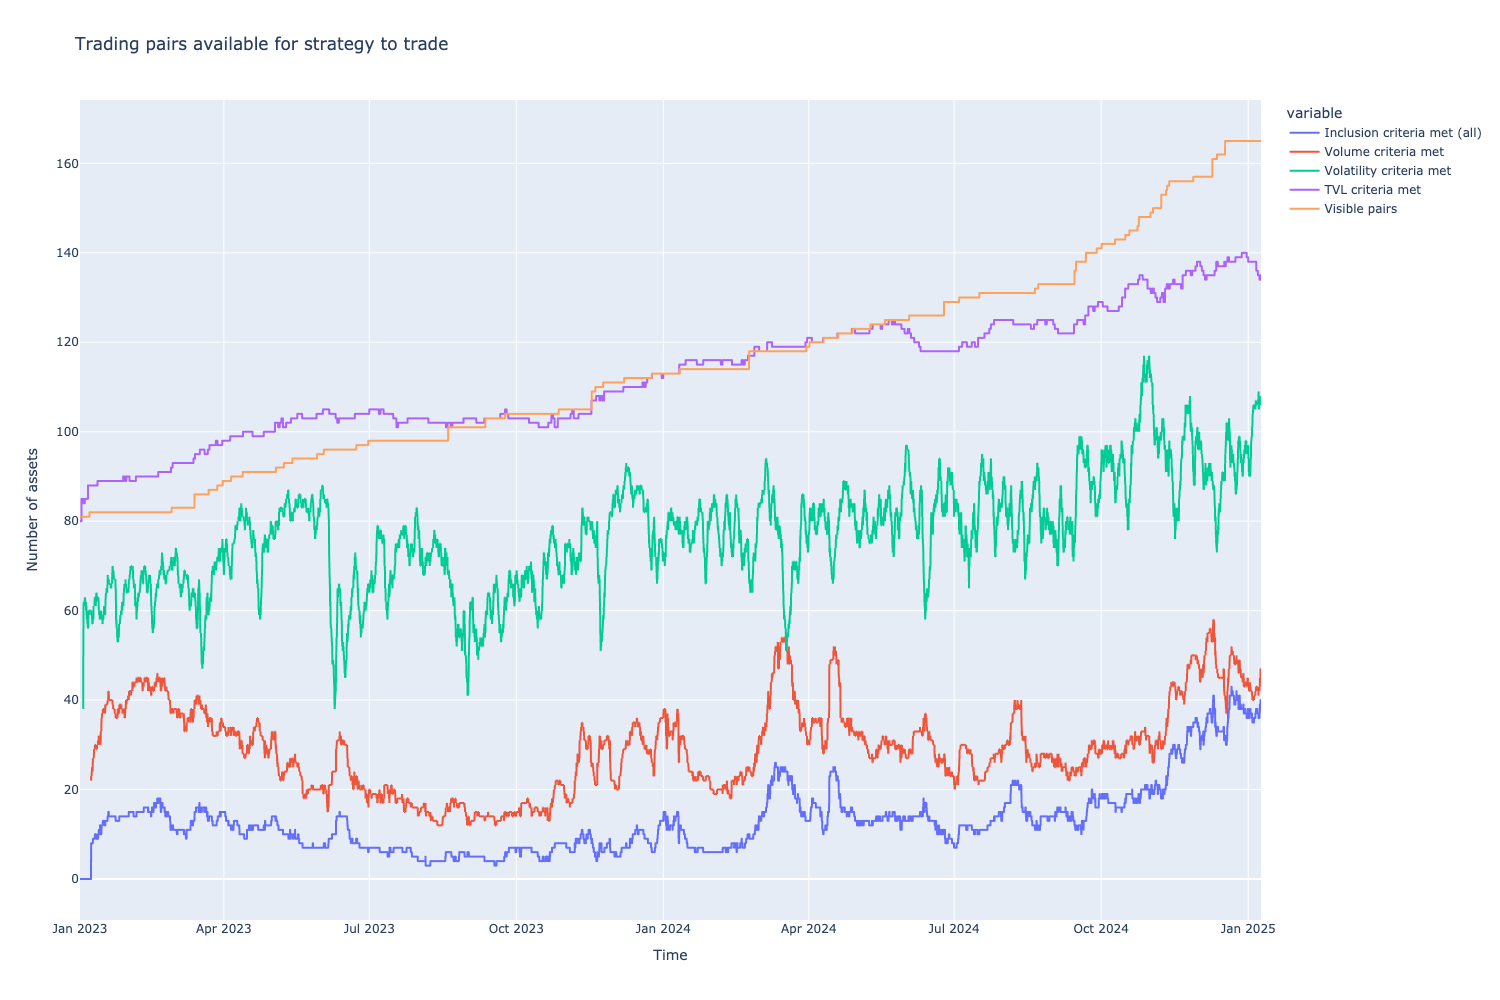

Inclusion criteria met (all)  Volume criteria met  \
2025-01-08 20:00:00                            40                 47.0   
2025-01-08 21:00:00                            40                 47.0   
2025-01-08 22:00:00                            40                 47.0   
2025-01-08 23:00:00                            40                 47.0   
2025-01-09 00:00:00                            40                 46.0   

                     Volatility criteria met  TVL criteria met  Visible pairs  
2025-01-08 20:00:00                    106.0               134            165  
2025-01-08 21:00:00                    106.0               134            165  
2025-01-08 22:00:00                    106.0               134            165  
2025-01-08 23:00:00                    106.0               134            165  
2025-01-09 00:00:00                    106.0               135            165

In [38]:
import plotly.express as px

df = pd.DataFrame({
    "Inclusion criteria met (all)": indicator_data.get_indicator_series("all_criteria_included_pair_count"),
    "Volume criteria met": indicator_data.get_indicator_series("volume_included_pair_count"),
    "Volatility criteria met": indicator_data.get_indicator_series("volatility_included_pair_count"),
    "TVL criteria met": indicator_data.get_indicator_series("tvl_included_pair_count"),
    "Visible pairs": indicator_data.get_indicator_series("trading_pair_count"),
})

fig = px.line(df, title='Trading pairs available for strategy to trade')
fig.update_yaxes(title="Number of assets")
fig.update_xaxes(title="Time")
fig.show()

display(df.tail(5))

Find the first availability, or admission to index, of all trading pairs.

In [39]:
from tradingstrategy.liquidity import LiquidityDataUnavailable

series = indicator_data.get_indicator_series("inclusion_criteria")

exploded = series.explode()
first_appearance_series = exploded.groupby(exploded.values).apply(lambda x: x.index[0])

df = pd.DataFrame({
    "Included at": first_appearance_series
})

def _get_ticker(pair_id):
    try:
        return strategy_universe.get_pair_by_id(pair_id).get_ticker()
    except Exception:
        return "<pair metadata missing>"

df["Ticker"] = first_appearance_series.index.map(_get_ticker)
df["DEX"] = first_appearance_series.index.map(lambda pair_id: strategy_universe.get_pair_by_id(pair_id).exchange_name)
df = df.sort_values("Included at")

def _map_tvl(row):
    pair_id = row.name  # Indxe
    timestamp = row["Included at"]
    try:
        tvl, delay = strategy_universe.data_universe.liquidity.get_liquidity_with_tolerance(
            pair_id,
            timestamp,
            tolerance=pd.Timedelta(days=2),
        )
        return tvl
    except LiquidityDataUnavailable:
        # TODO Data dates mismatch?
        return 0 

# Get the first entry and value of rolling cum volume of each pair
volume_series = indicator_data.get_indicator_data_pairs_combined("rolling_cumulative_volume")
first_volume_df = volume_series.reset_index().groupby("pair_id").first()

def _map_volume_timestamp(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["timestamp"]
    except KeyError:
        return None
    
def _map_volume_value(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["value"]
    except KeyError:
        return None

df["TVL at inclusion"] = df.apply(_map_tvl, axis=1)
df["Rolling volume first entry at"] = df.apply(_map_volume_timestamp, axis=1)
df["Rolling volume initial"] = df.apply(_map_volume_value, axis=1)

print(f"First appearances of {len(df)} trading pairs, when they meet all inclusion criteria:")

with pd.option_context("display.float_format", "{:,.2f}".format):
    display(df)


First appearances of 112 trading pairs, when they meet all inclusion criteria:


Included at         Ticker             DEX  TVL at inclusion  \
1369371 2023-01-07 23:00:00    BSCPAD-WBNB  pancakeswap-v2        886,289.62   
1387782 2023-01-07 23:00:00       ALU-WBNB  pancakeswap-v2        795,579.64   
1364786 2023-01-07 23:00:00      LINK-WBNB  pancakeswap-v2      8,476,462.48   
1634297 2023-01-07 23:00:00      NFTB-WBNB  pancakeswap-v2        391,753.02   
1897404 2023-01-07 23:00:00       ROO-USDT  pancakeswap-v2      2,077,299.75   
1370397 2023-01-07 23:00:00      DOGE-WBNB  pancakeswap-v2      1,436,268.07   
2311899 2023-01-07 23:00:00        VS-USDT  pancakeswap-v2        874,880.97   
1638013 2023-01-07 23:00:00      CAPS-WBNB  pancakeswap-v2        259,066.35   
1998420 2023-01-09 02:00:00      CENX-WBNB  pancakeswap-v2        762,129.56   
2500300 2023-01-10 08:00:00       DAO-USDT  pancakeswap-v2      1,801,144.49   
1364794 2023-01-12 18:00:00       XVS-WBNB  pancakeswap-v2      1,084,206.98   
2874115 2023-01-13 13:00:00       GRV-WBNB  pancakeswap-v2      1,057,046.52   
1616828 2023-01-14 09:00:00      AIRI-WBNB  pancakeswap-v2        616,855.06   
1364863 2023-01-15 07:00:00       LTC-WBNB  pancakeswap-v2      3,238,657.40   
2615639 2023-01-18 07:00:00      wALV-WBNB  pancakeswap-v2      1,535,074.35   
1836298 2023-01-18 17:00:00      TCG2-WBNB  pancakeswap-v2        977,353.95   
1377353 2023-01-25 14:00:00      POLS-WBNB  pancakeswap-v2        973,688.43   
2472992 2023-02-05 09:00:00      SAFE-USDT  pancakeswap-v2      2,002,465.42   
2484741 2023-03-08 18:00:00    zksync-USDT  pancakeswap-v2        979,498.29   
2963590 2023-03-13 15:00:00      GFAL-USDT  pancakeswap-v2        624,428.19   
2926225 2023-03-14 15:00:00     SAKAI-USDT  pancakeswap-v2        592,515.86   
2962630 2023-03-17 10:00:00      LAND-WBNB  pancakeswap-v2        820,349.40   
2085156 2023-03-20 14:00:00       APX-WBNB  pancakeswap-v2      3,183,337.90   
2582981 2023-03-29 11:00:00       UVT-USDT  pancakeswap-v2      1,863,806.24   
2999965 2023-04-05 14:00:00     METFI-USDT  pancakeswap-v2      1,083,653.80   
1364935 2023-04-07 07:00:00      BELT-WBNB  pancakeswap-v2      1,501,856.03   
1371097 2023-04-15 12:00:00       FIL-USDT  pancakeswap-v2      3,464,410.18   
1818443 2023-04-26 00:00:00       PVU-USDT  pancakeswap-v2        668,881.33   
1684215 2023-04-26 18:00:00      CATE-WBNB  pancakeswap-v2      3,379,878.30   
3042961 2023-05-03 14:00:00       SCT-USDT  pancakeswap-v2      2,063,192.15   
1626541 2023-05-15 12:00:00      MINT-WBNB  pancakeswap-v2        594,075.78   
1892440 2023-06-02 14:00:00       STA-USDT  pancakeswap-v2      5,163,373.99   
2172165 2023-08-26 08:00:00       POT-USDT  pancakeswap-v2      1,194,279.76   
3061826 2023-09-18 15:00:00      HyPC-WBNB  pancakeswap-v2        927,762.71   
3324151 2023-09-24 01:00:00       CAP-USDT  pancakeswap-v2      1,080,840.90   
1819739 2023-10-01 00:00:00      RACA-WBNB  pancakeswap-v2      1,158,047.33   
3086764 2023-10-23 08:00:00     TRUST-USDT  pancakeswap-v2      1,279,760.04   
1364815 2023-11-25 03:00:00       XRP-WBNB  pancakeswap-v2        518,892.88   
1688868 2023-11-28 09:00:00      HERO-WBNB  pancakeswap-v2      9,617,189.98   
1949508 2023-12-01 19:00:00       DAR-WBNB  pancakeswap-v2        613,202.95   
1691693 2023-12-12 12:00:00     BRISE-WBNB  pancakeswap-v2      1,036,823.13   
3405975 2023-12-14 11:00:00       MTC-USDT  pancakeswap-v2        492,667.44   
1364896 2023-12-16 14:00:00       SFP-WBNB  pancakeswap-v2      3,204,140.26   
1364825 2023-12-27 03:00:00       UNI-WBNB  pancakeswap-v2        463,214.55   
1759053 2023-12-28 05:00:00       SPS-WBNB  pancakeswap-v2      1,737,023.01   
1370830 2024-01-01 05:00:00       ETH-USDT  pancakeswap-v2      1,423,901.89   
3289110 2024-02-19 00:00:00    AITECH-USDT  pancakeswap-v2        291,091.30   
3536478 2024-02-27 14:00:00       MGC-WBNB  pancakeswap-v2        394,808.76   
1603531 2024-03-05 08:00:00      BMON-WBNB  pancakeswap-v2        783,226.63   
3405844 2024-03-

# Signal across pairs

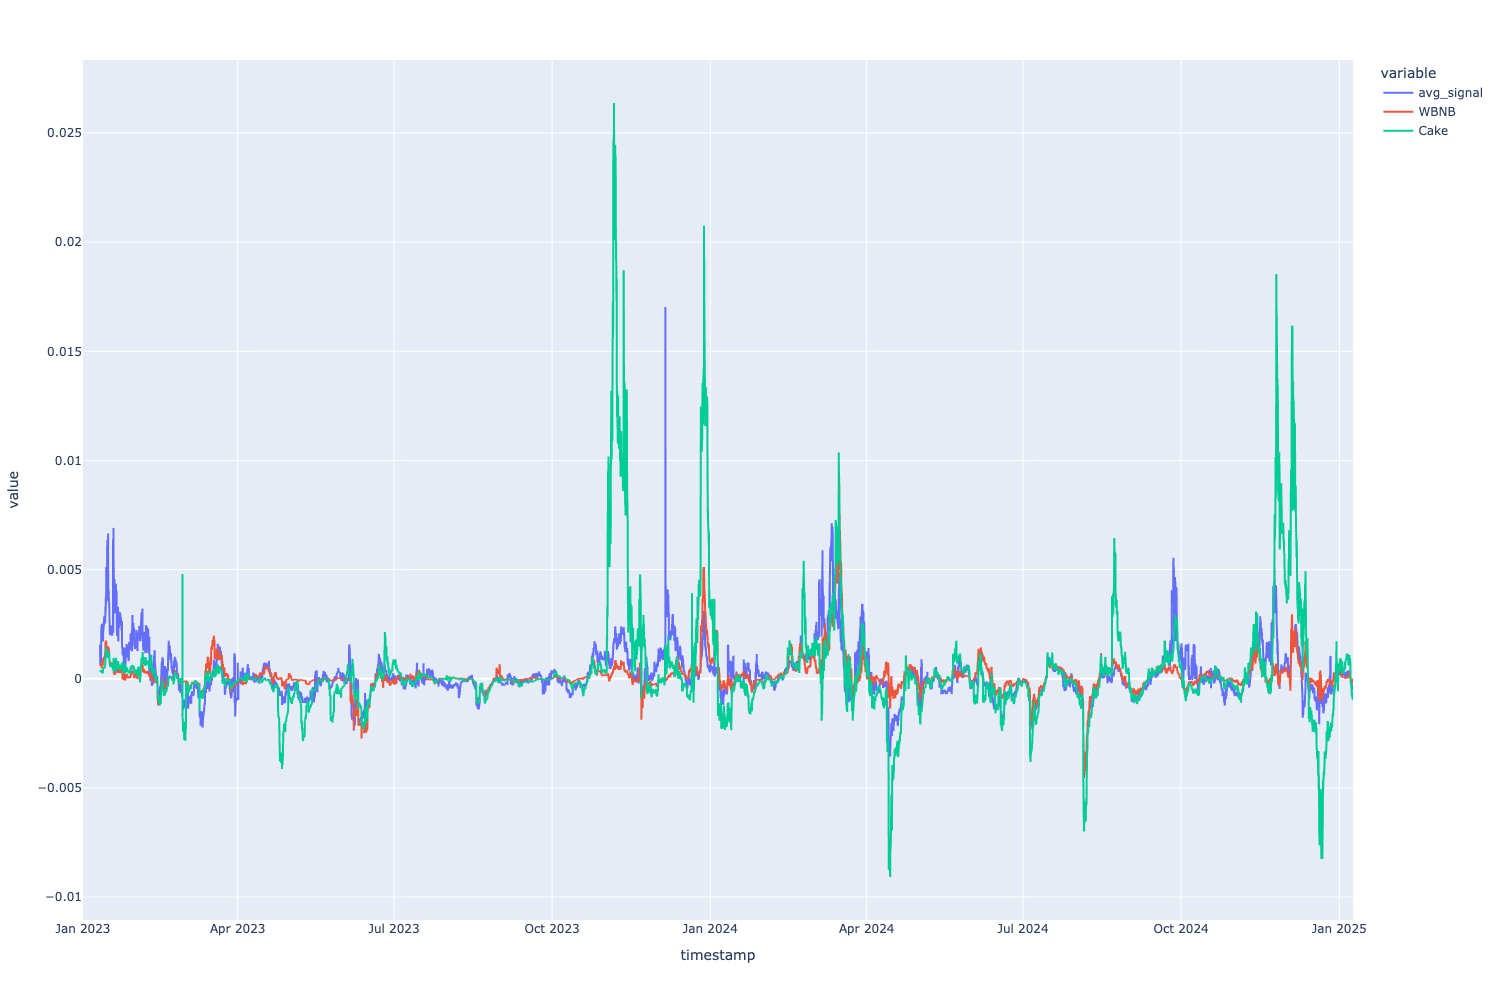

In [40]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS[0:2]

# max_displayed_vol = avg_signal.max() * 1.1
upper_displayed = 0.1

avg_signal = indicator_data.get_indicator_series("avg_signal")

data = {
    "avg_signal": avg_signal.clip(upper=upper_displayed),
}


# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    signal = indicator_data.get_indicator_series("volatility_returns_indicator", pair=pair)
    signal = signal.clip(upper=upper_displayed)
    data[symbol] = signal
    
df = pd.DataFrame(data)
fig = px.line(df)
fig.show()


# Volatility across pairs

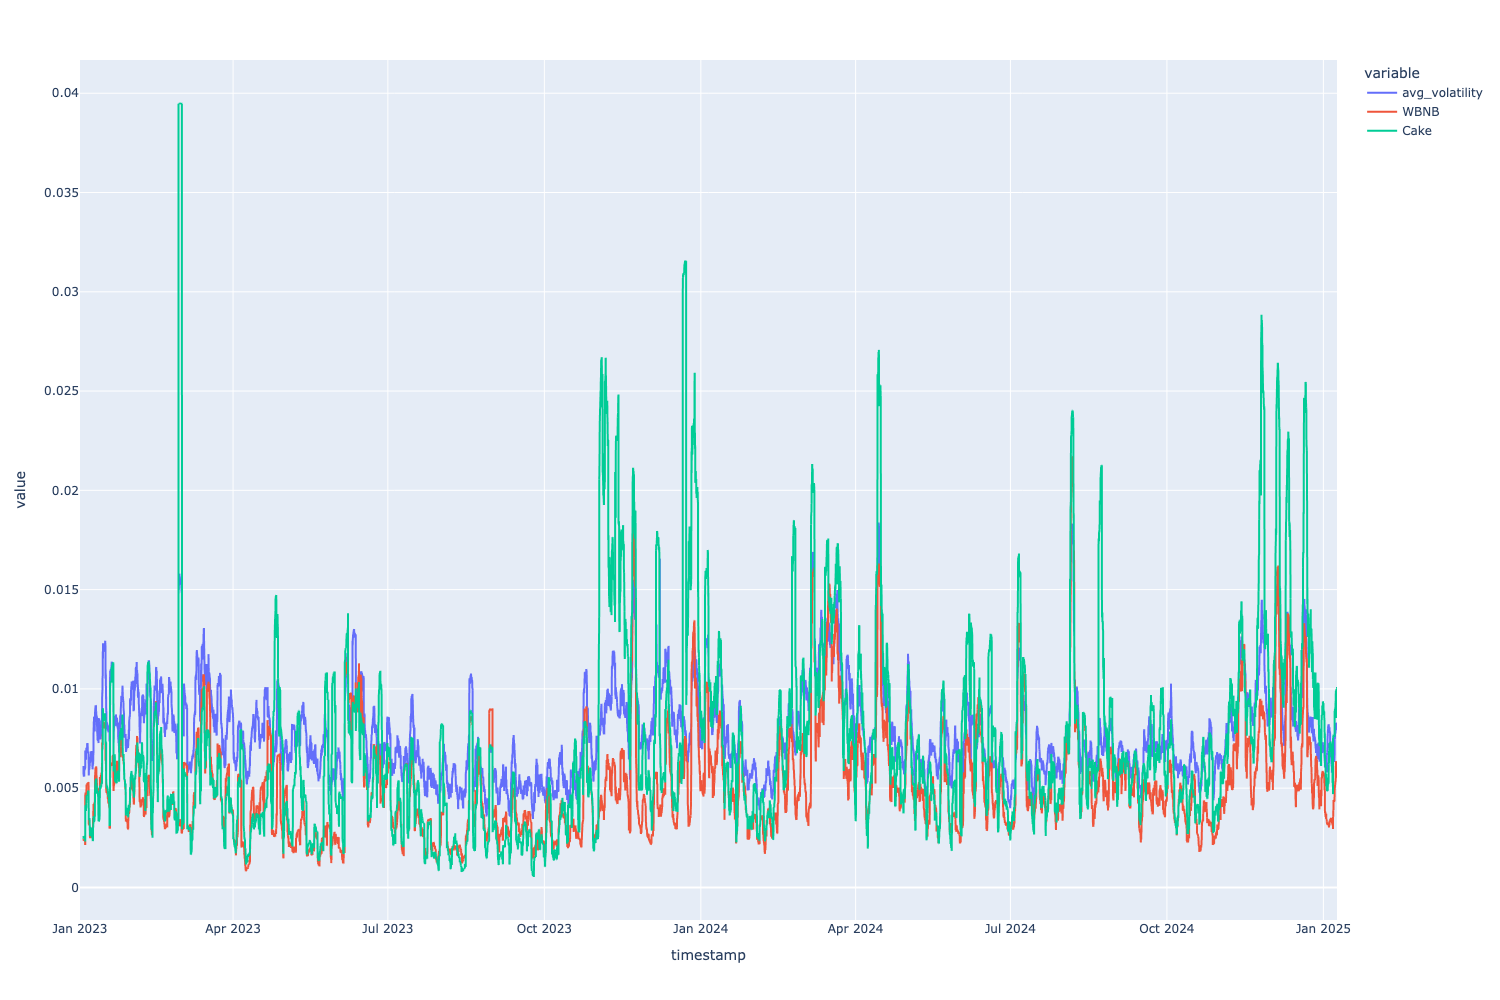

In [41]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS[0:2]

avg_volatility = indicator_data.get_indicator_series("avg_volatility")

volatilities = {
    "avg_volatility": avg_volatility,
}

max_displayed_vol = avg_volatility.max() * 3

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    volatility = indicator_data.get_indicator_series("volatility", pair=pair)
    volatility = volatility.clip(upper=max_displayed_vol)
    volatilities[symbol] = volatility
    
volatility_df = pd.DataFrame(volatilities)
fig = px.line(volatility_df)
fig.show()


# Price vs. signal

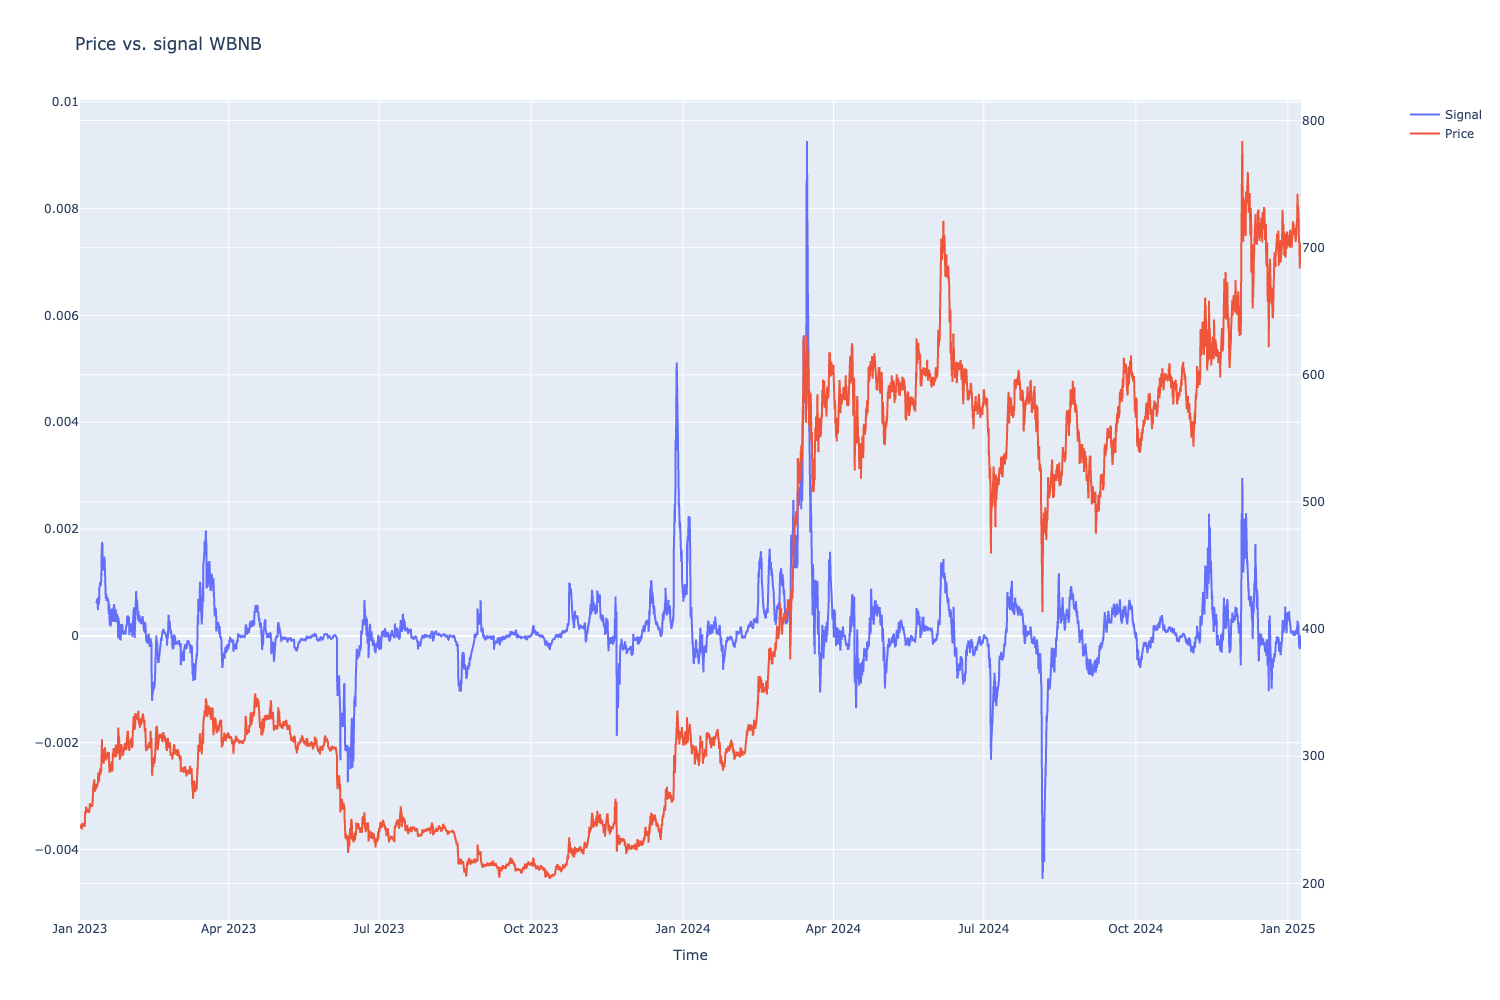

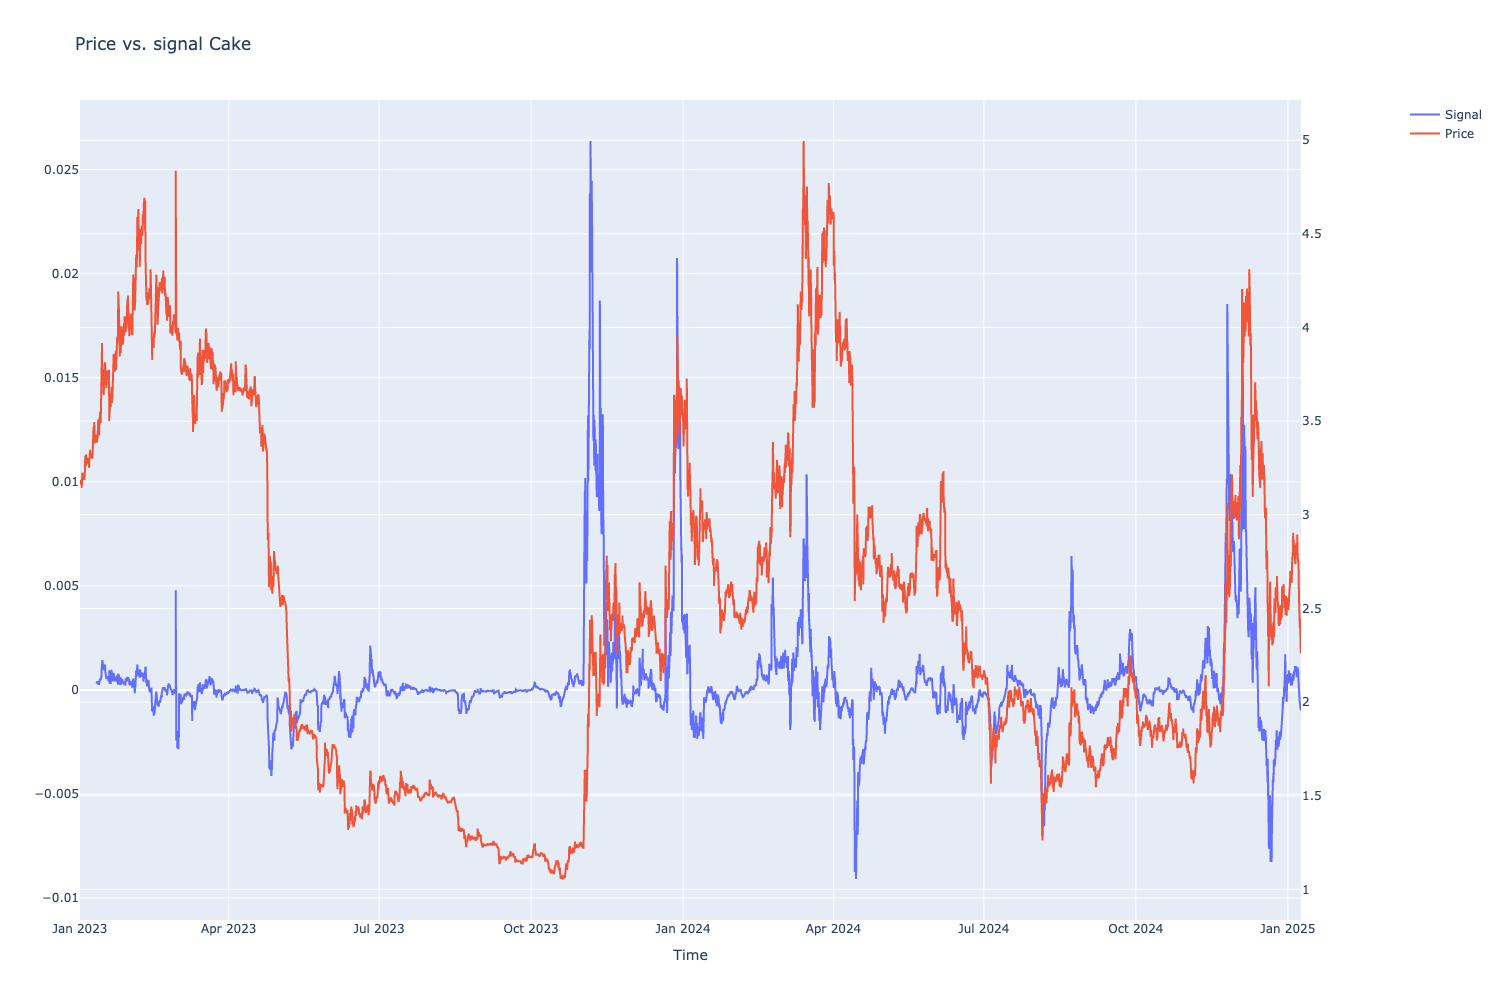

In [42]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS[0:2]

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("volatility_returns_indicator", pair=pair)    
    volatility = indicator_data.get_indicator_series("volatility", pair=pair)

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
        # "volatility": volatility,
    })

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="Signal"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. signal {symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Price vs. volatility

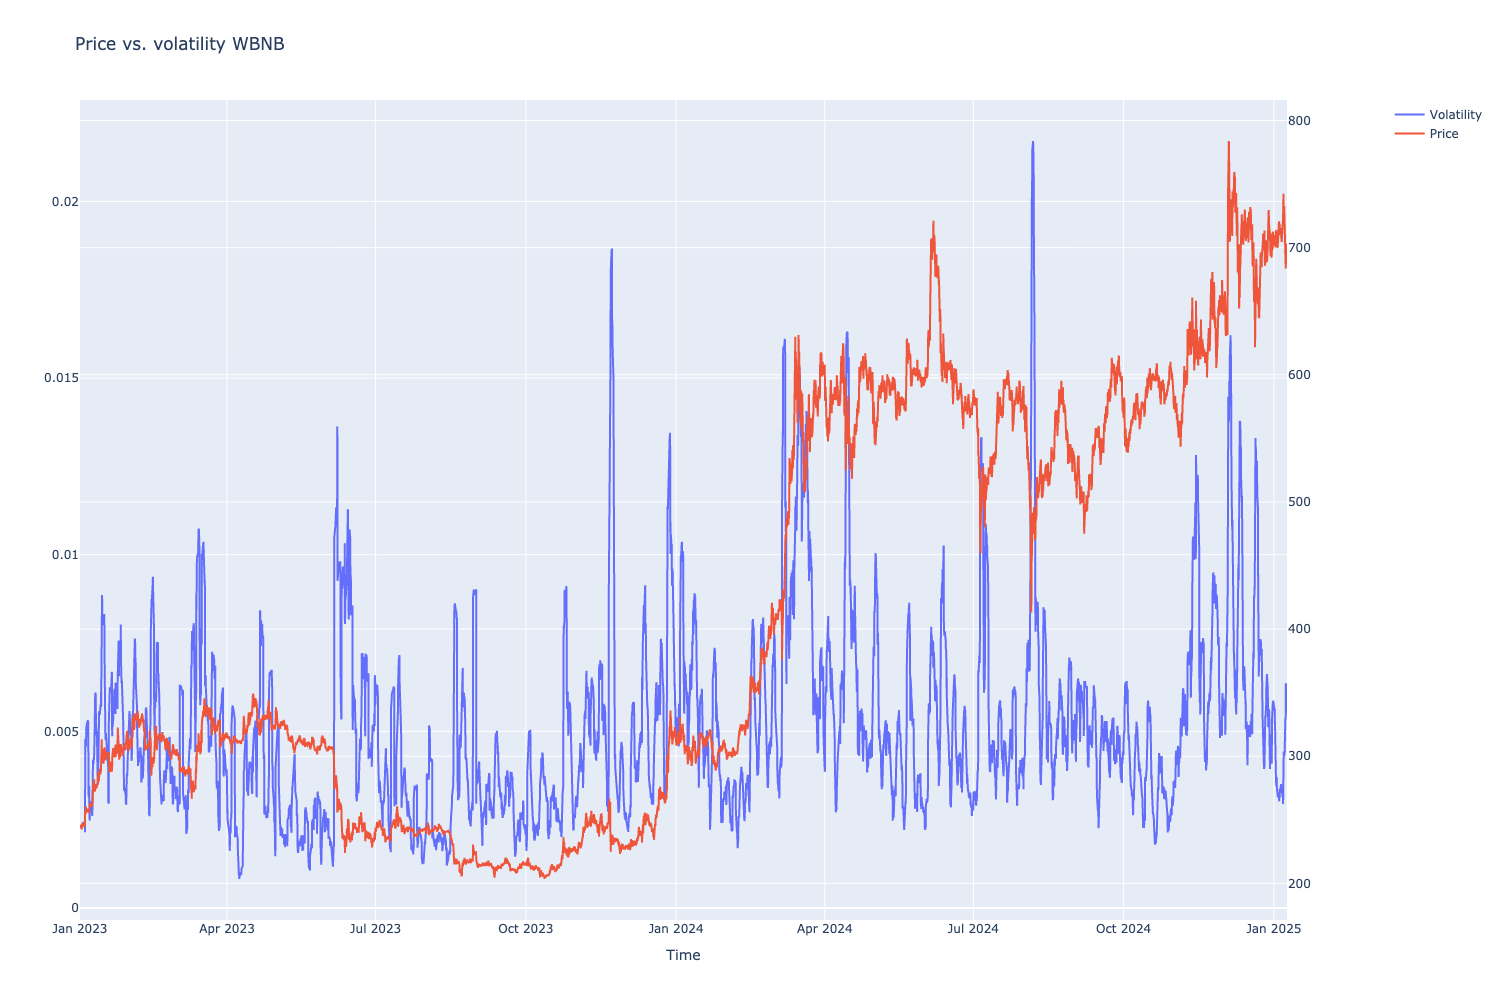

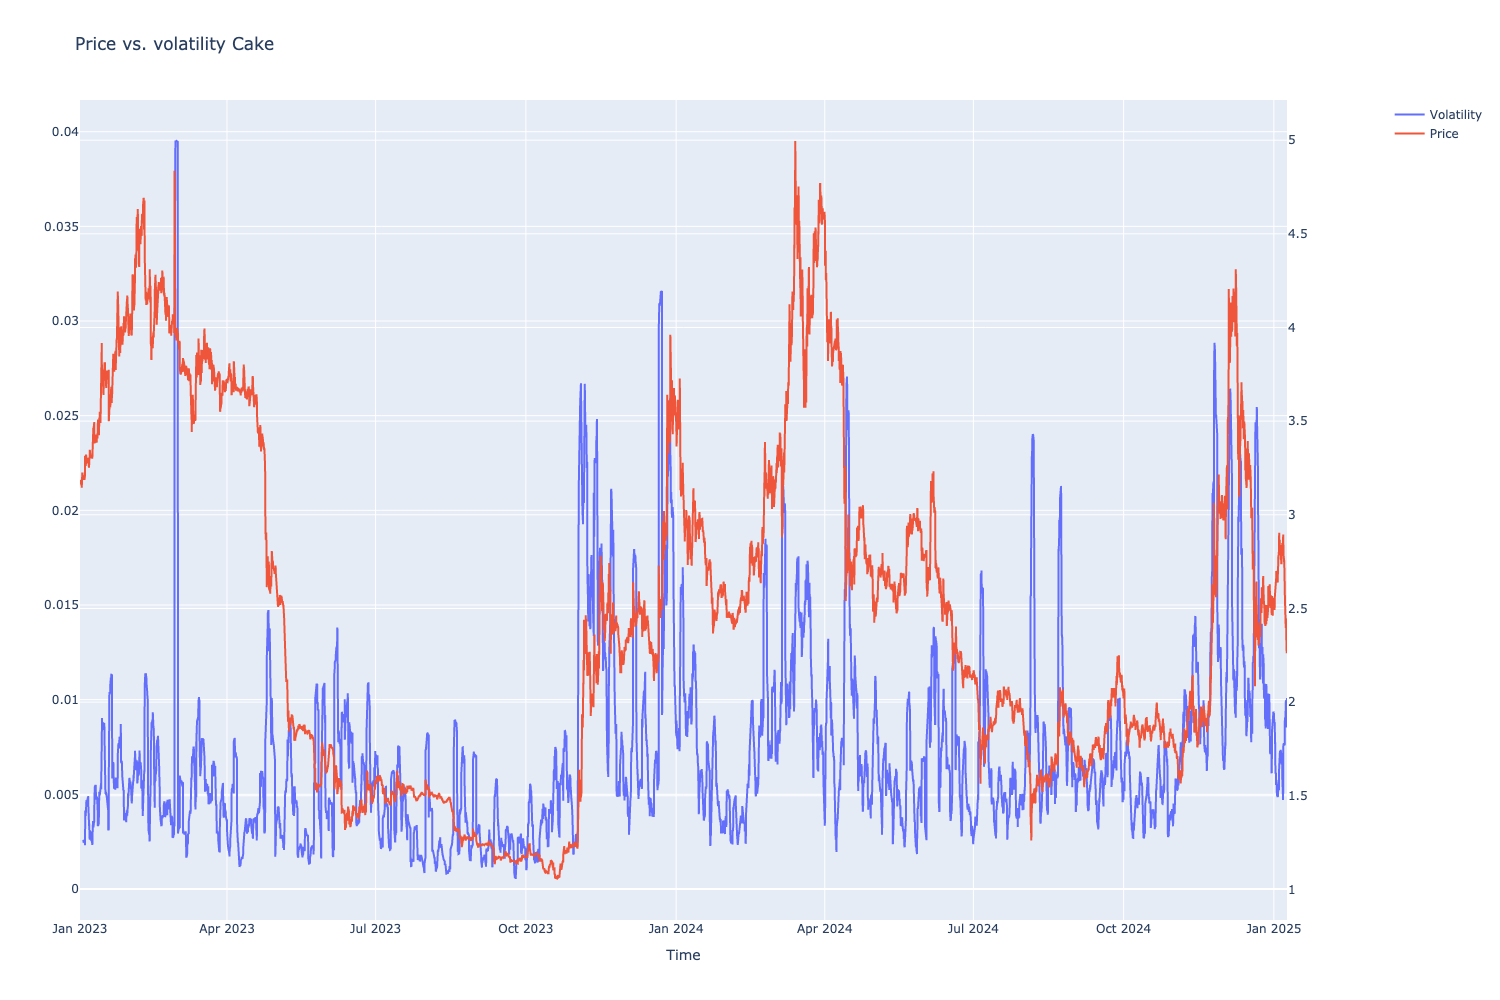

In [43]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS[0:2]

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("volatility_returns_indicator", pair=pair)    
    volatility = indicator_data.get_indicator_series("volatility", pair=pair)

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
        "volatility": volatility,
    })

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["volatility"], name="Volatility"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. volatility {symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Price vs. ATH indicator

- Plot ATH indicator

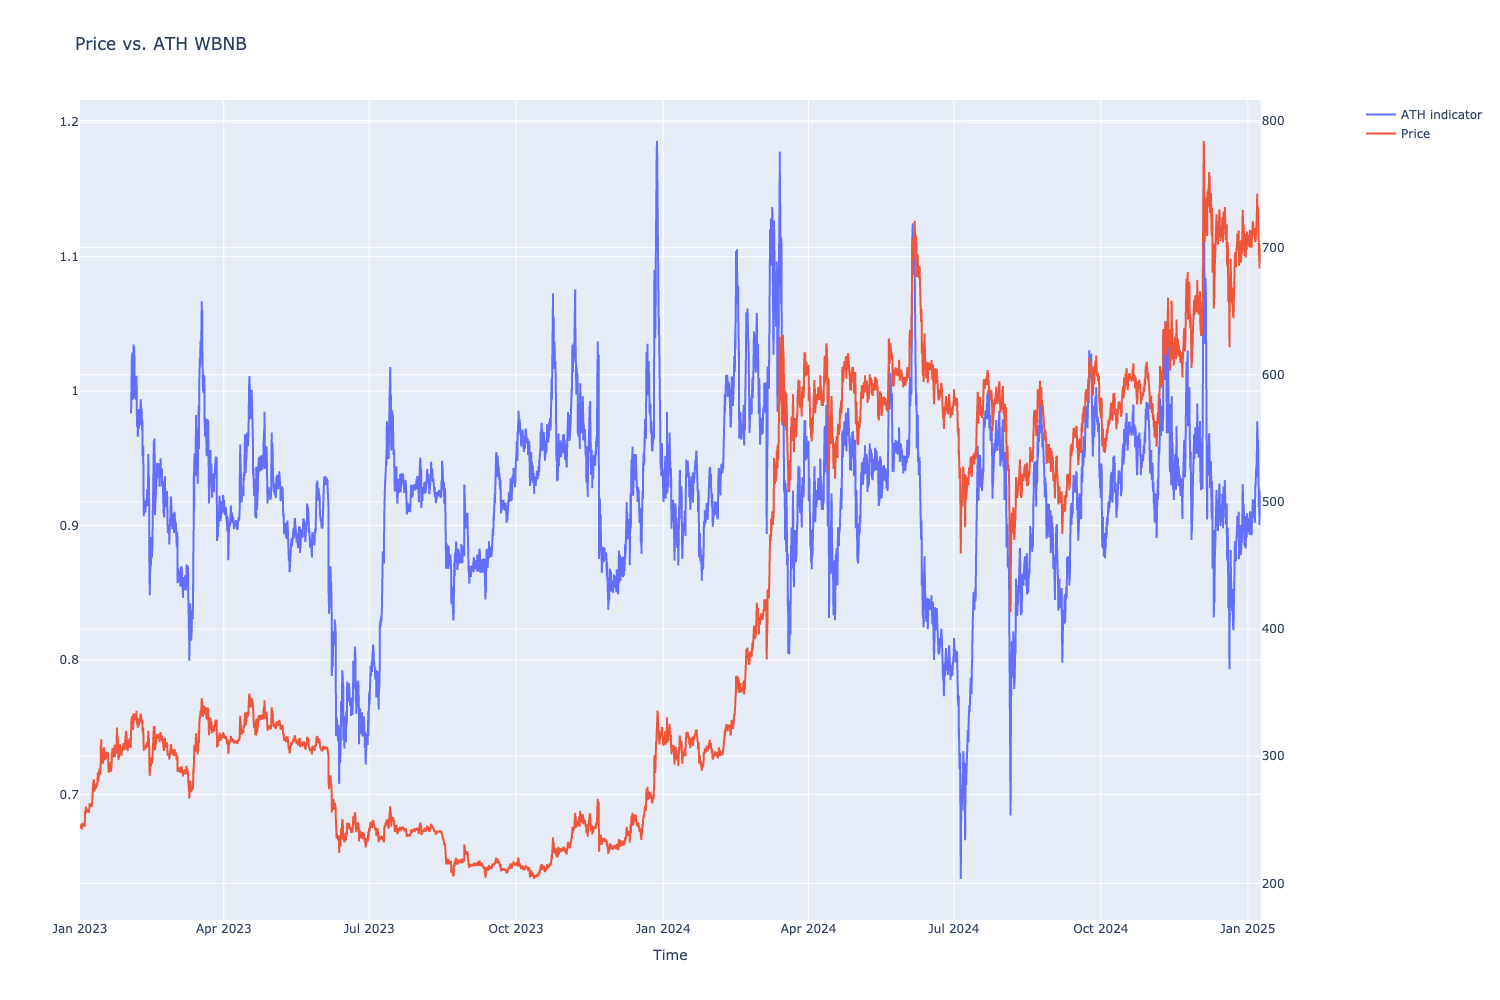

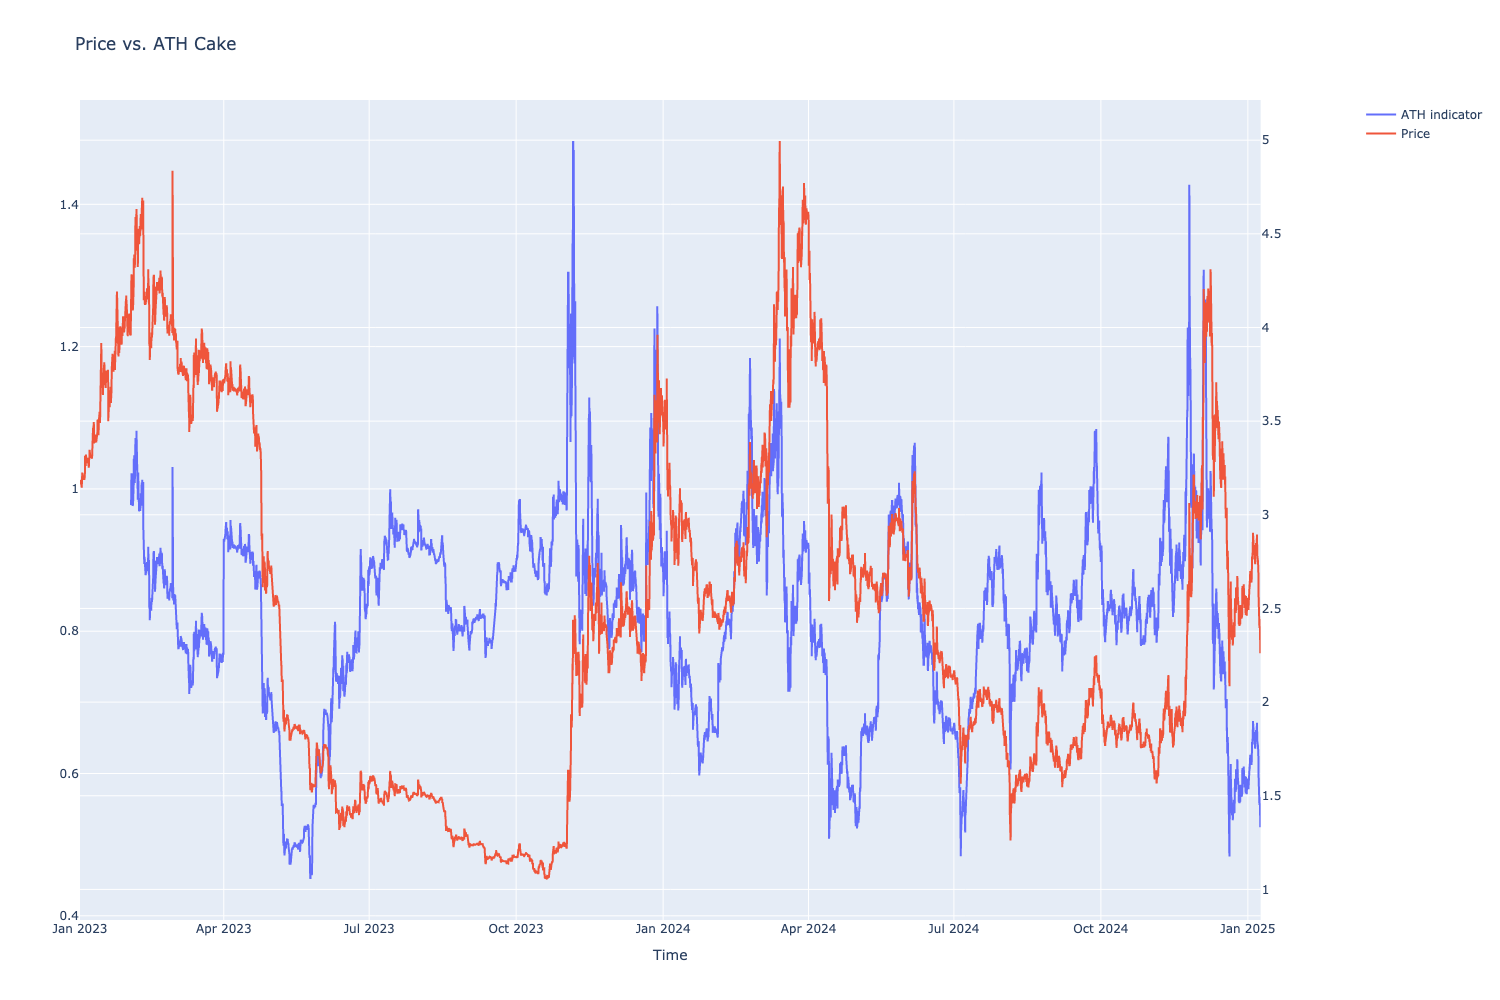

In [44]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS[0:2]

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("ath", pair=pair)    

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
    })

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="ATH indicator"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. ATH {symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Regime

- Are we in bull or bear regime

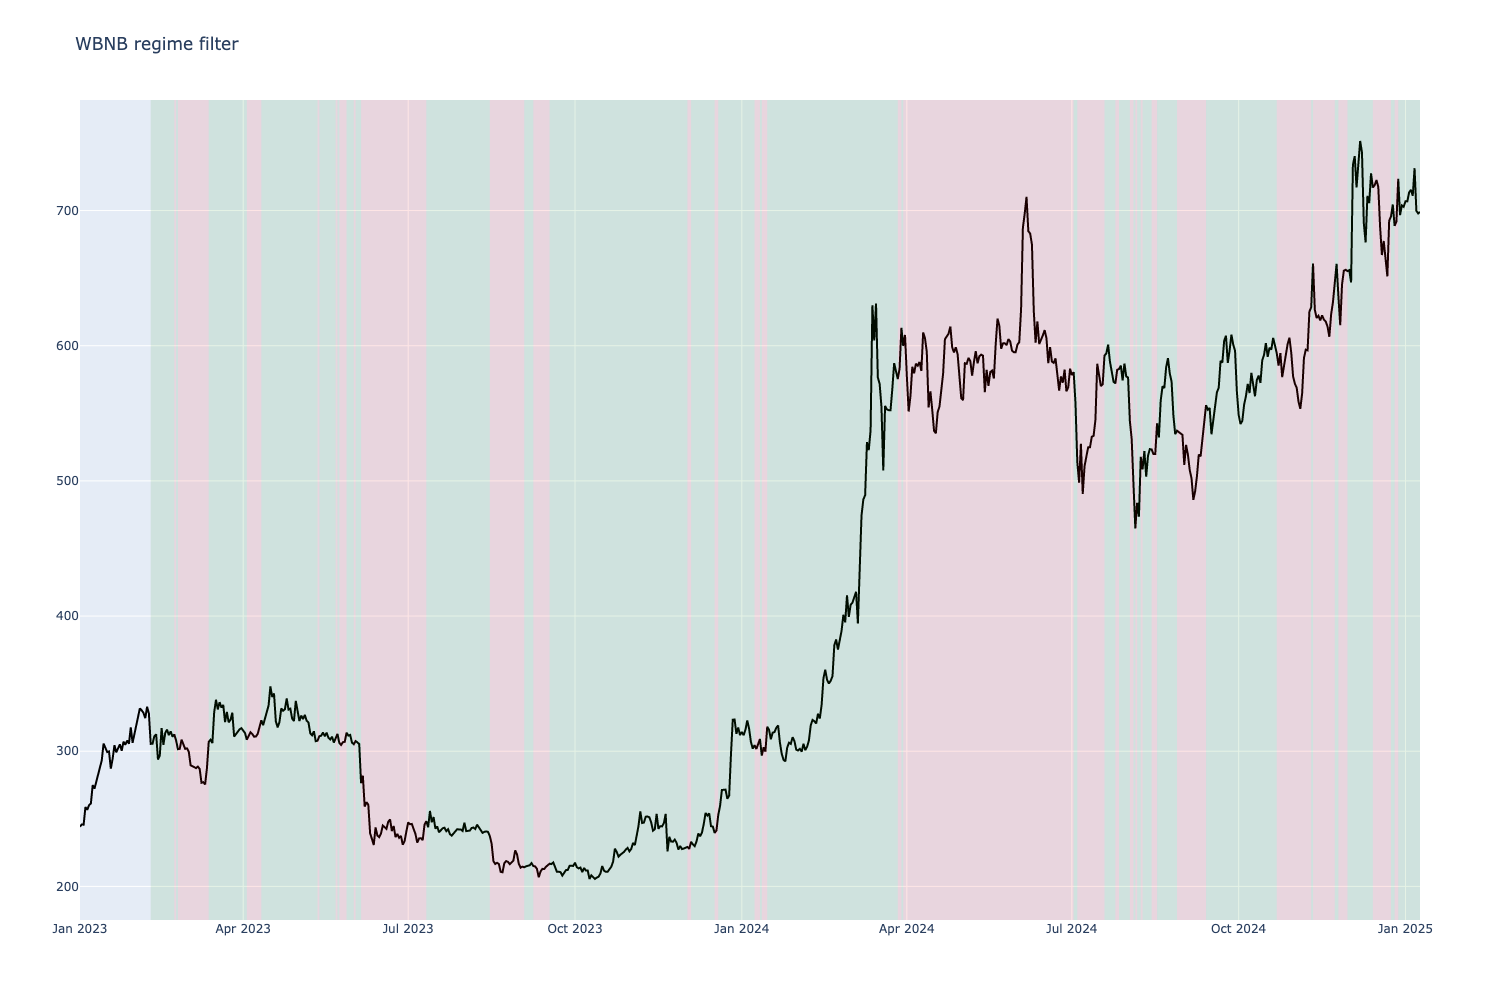

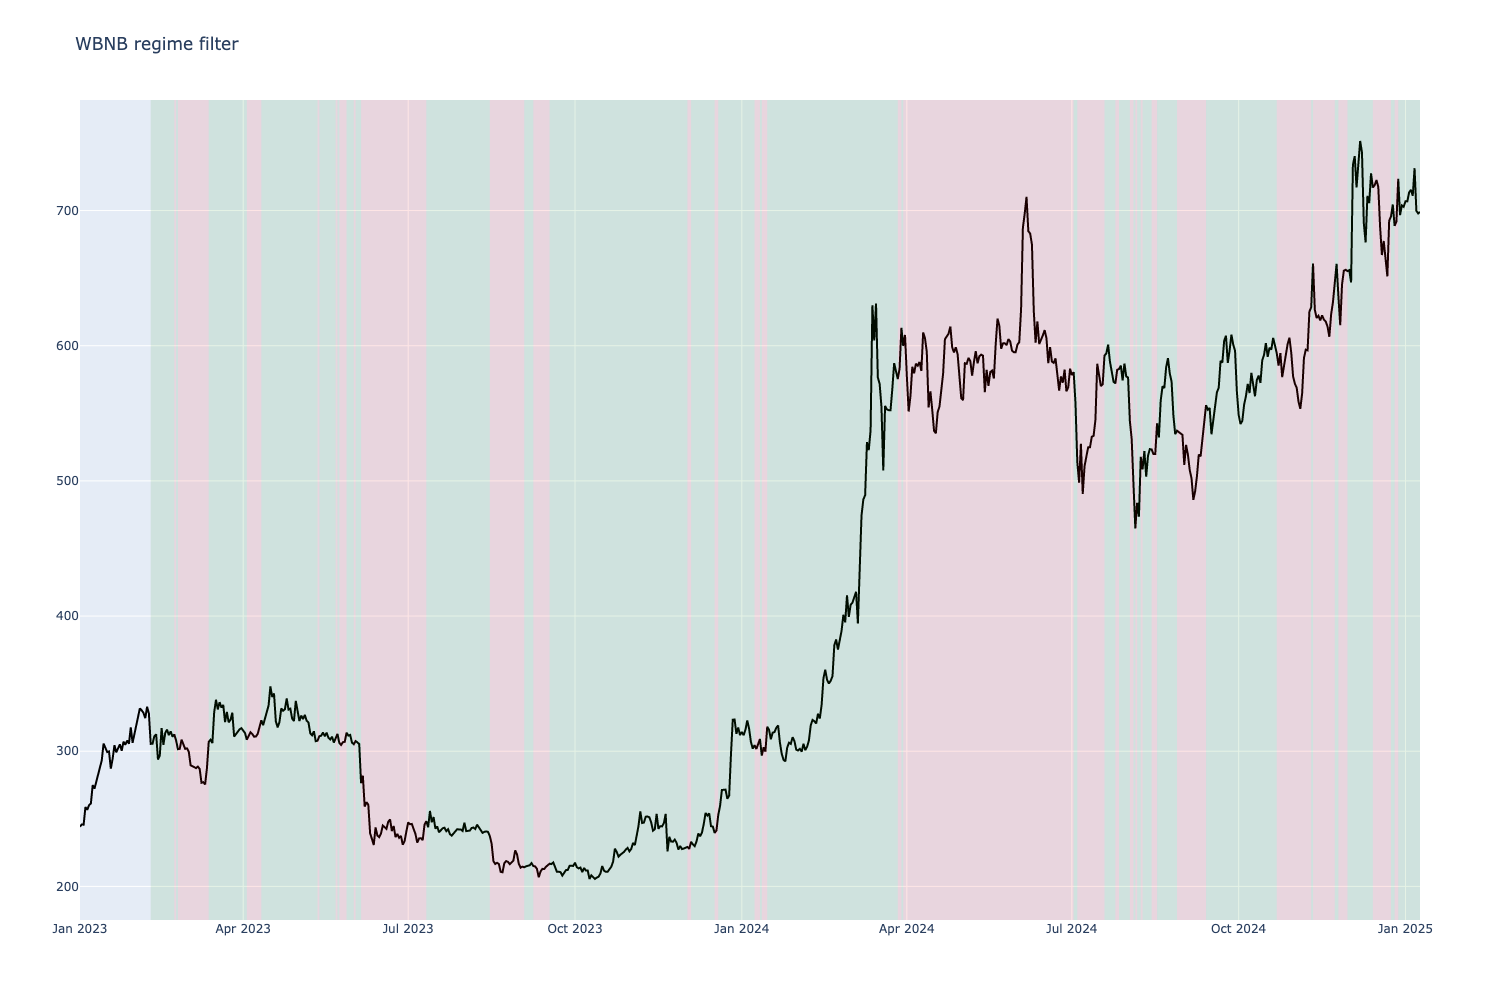

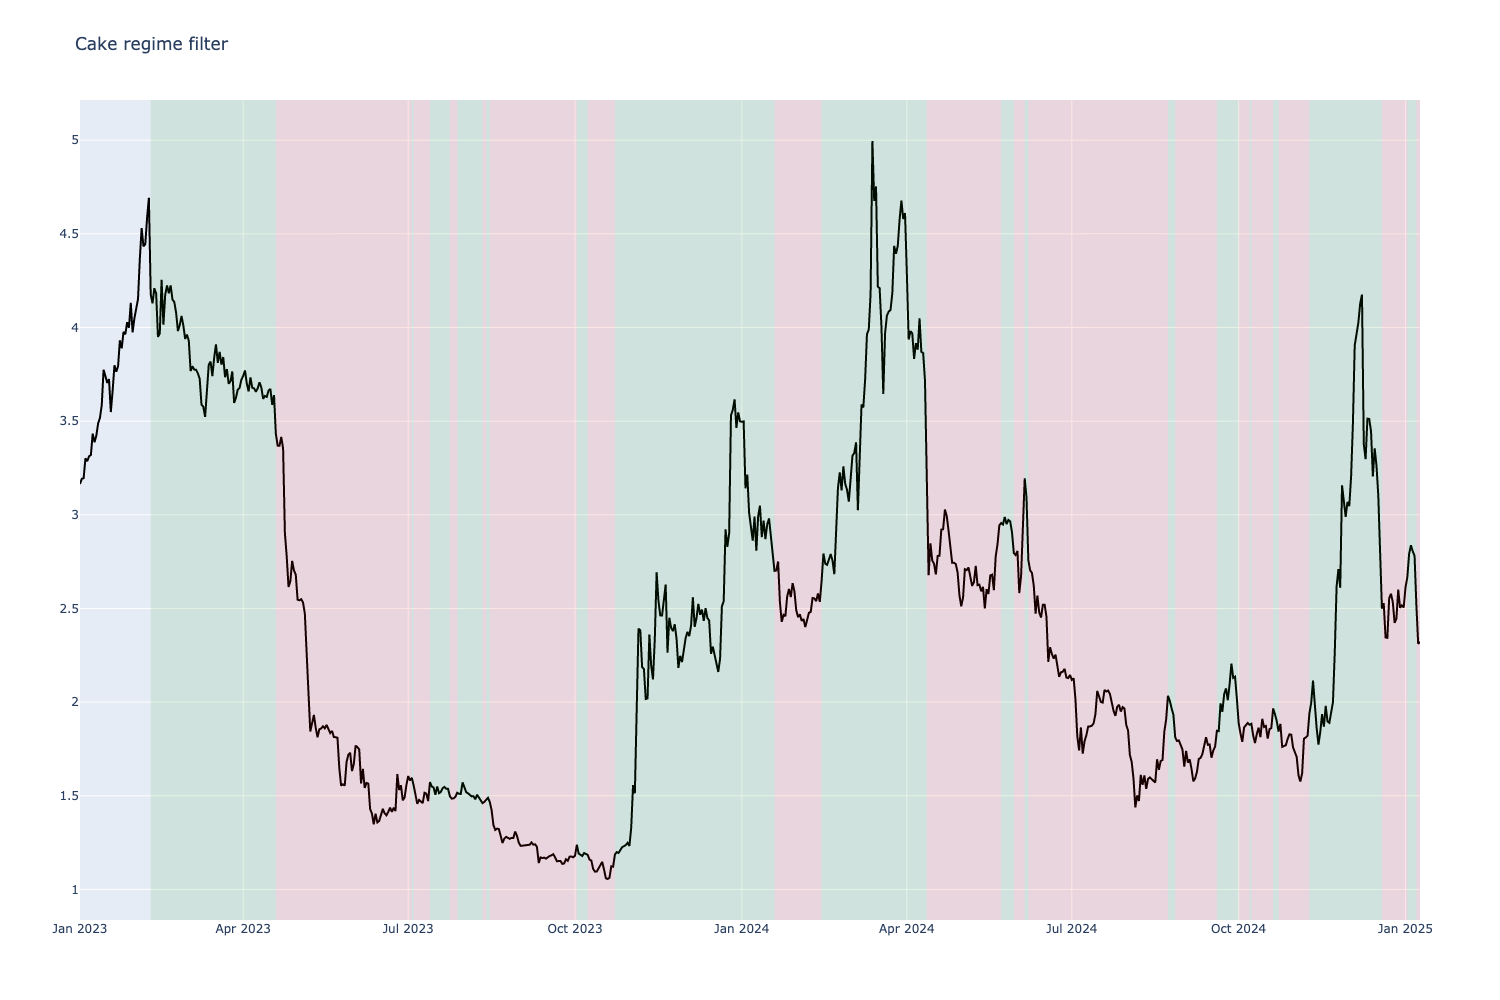

In [45]:
from tradeexecutor.visual.bullbear import visualise_market_regime_filter
from tradeexecutor.visual.bullbear import visualise_raw_market_regime_indicator

for pair_desc in [VOL_PAIR] + EXAMINED_ASSETS[0:2]:
    if pair_desc == VOL_PAIR:
        pair = strategy_universe.get_pair_by_human_description(pair_desc)
    else:
        pair = token_map[pair_desc]

    # Pull the pair and its close price we are detecting regimes for
    ohlcv = indicator_data.get_ohlcv(pair=pair)
    ohlcv = resample_candles(ohlcv, "1D")
    close_price = ohlcv["close"]

    regime_signal = indicator_data.get_indicator_series("regime", pair=pair, unlimited=True)
    regime_signal = regime_signal.resample("1D").last()
    figure = visualise_market_regime_filter(
        close_price,
        regime_signal,
        title=f"{pair.base.token_symbol} regime filter"
    )
    figure.show()

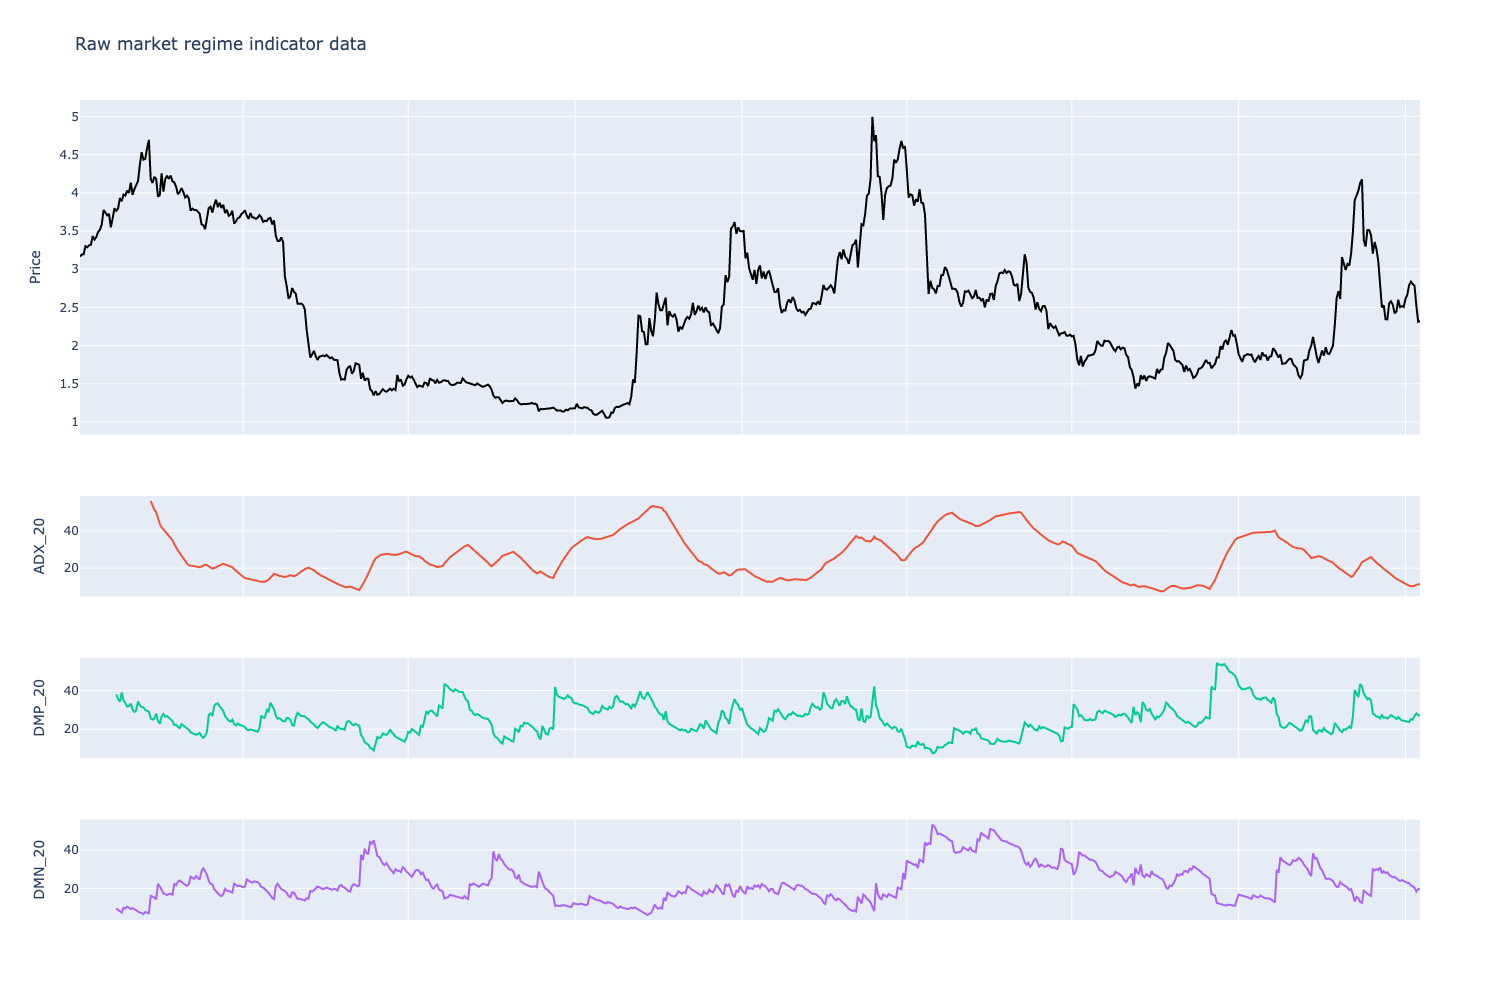

In [46]:
from tradeexecutor.visual.bullbear import visualise_raw_market_regime_indicator

pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
adx_df = indicator_data.get_indicator_dataframe("daily_adx", pair=pair)

visualise_raw_market_regime_indicator(
    close_price, 
    adx_df,
    height=500,
    indicator_height=150,
)


# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [47]:
series = indicator_data.get_indicator_series("all_criteria_included_pair_count")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = Parameters.backtest_start
backtest_end = Parameters.backtest_end

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2023-01-01 00:00:00 - 2025-01-09 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [48]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, IndicatorDataNotFoundWithinDataTolerance
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh, weight_equal
from tradeexecutor.utils.dedent import dedent_any


def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    # Build signals for each pair 
    alpha_model = AlphaModel(
        timestamp,
        close_position_weight_epsilon=parameters.min_portfolio_weight,  # 10 BPS is our min portfolio weight
    )

    # Prepare diagnostics variables
    max_vol = (0, None)  
    signal_count = 0  
    vol_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    volume_included_pair_count = indicators.get_indicator_value(
        "volume_included_pair_count",
    )
    volatility_included_pair_count = indicators.get_indicator_value(
        "volatility_included_pair_count",
    ) 
    tvl_included_pair_count = indicators.get_indicator_value(
        "tvl_included_pair_count",
    )
    
    # Get pairs included in this rebalance cycle.
    # This includes pair that have been pre-cleared in inclusion_criteria()
    # with volume, volatility and TVL filters 
    included_pairs = indicators.get_indicator_value(
        "inclusion_criteria",
        na_conversion=False,
    )
    if included_pairs is None:
        included_pairs = []

    clipped_pairs = 0

    avg_signal = indicators.get_indicator_value("avg_signal")
    if avg_signal is None:
        return []
    
    # Set signal for each pair
    for pair_id in included_pairs:
        pair = strategy_universe.get_pair_by_id(pair_id)

        ath = indicators.get_indicator_value("ath", pair=pair)
        if ath is None:
            continue

        if ath < parameters.ath_filter:
            continue

        pair_signal = indicators.get_indicator_value("volatility_returns_indicator", pair=pair)
        if pair_signal is None:
            continue

        weight = pair_signal 

        if weight < 0:
            continue

        alpha_model.set_signal(
            pair,
            weight,
        )

        # Diagnostics reporting
        signal_count += 1


    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation

    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_passthrouh)
    # alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    # 
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=parameters.assummed_liquidity_when_data_missings,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=True,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)
    
    # rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    rebalance_threshold_usd = parameters.individual_rebalance_min_threshold_usd
    
    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
        execution_context=input.execution_context,
    )

    # Supply or withdraw cash to Aave if strategy is set to do so
    if parameters.use_aave:
        credit_deposit_flow = position_manager.calculate_credit_flow_needed(
            trades,
            parameters.allocation,
        )
        credit_flow_dust_threshold = 3.0  # Min deposit USD to Aave
        if credit_deposit_flow > credit_flow_dust_threshold:
            trades += position_manager.manage_credit_flow(credit_deposit_flow)
    else:
        credit_deposit_flow = 0

    # Add verbal report about decision made/not made,
    # so it is much easier to diagnose live trade execution.
    # This will be readable in Discord/Telegram logging.
    if input.is_visualisation_enabled():
        try:
            top_signal = next(iter(alpha_model.get_signals_sorted_by_weight()))
            if top_signal.normalised_weight == 0:
                top_signal = None
        except StopIteration:
            top_signal = None

        max_vol_pair = max_vol[1]
        if max_vol_pair:
            max_vol_signal = alpha_model.get_signal_by_pair(max_vol_pair)
        else:
            max_vol_signal = None

        vol_pair_vol = indicators.get_indicator_value("volatility_ewm", pair=vol_pair)

        rebalance_volume = sum(t.get_value() for t in trades)
        
        report = dedent_any(f"""
        Cycle: #{input.cycle}
        Rebalanced: {'👍' if alpha_model.is_rebalance_triggered() else '👎'}
        Open/about to open positions: {len(state.portfolio.open_positions)} 
        Max position value change: {alpha_model.max_position_adjust_usd:,.2f} USD
        Rebalance threshold: {alpha_model.position_adjust_threshold_usd:,.2f} USD
        Trades decided: {len(trades)}
        Pairs total: {strategy_universe.data_universe.pairs.get_count()}
        Pairs meeting inclusion criteria: {len(included_pairs)}
        Pairs meeting volume inclusion criteria: {volume_included_pair_count}
        Pairs meeting volatility inclusion criteria: {volatility_included_pair_count}        
        Pairs meeting TVL inclusion criteria: {tvl_included_pair_count}        
        Pairs under volatility threshold: {clipped_pairs}        
        Signals created: {signal_count}
        Total equity: {portfolio.get_total_equity():,.2f} USD
        Cash: {position_manager.get_current_cash():,.2f} USD
        Investable equity: {alpha_model.investable_equity:,.2f} USD
        Accepted investable equity: {alpha_model.accepted_investable_equity:,.2f} USD
        Allocated to signals: {alpha_model.get_allocated_value():,.2f} USD
        Discarted allocation because of lack of lit liquidity: {alpha_model.size_risk_discarded_value:,.2f} USD
        Credit deposit flow: {credit_deposit_flow:,.2f} USD
        Rebalance volume: {rebalance_volume:,.2f} USD
        {vol_pair.base.token_symbol} volatility: {vol_pair_vol}        
        Most volatility pair: {max_vol_pair.get_ticker() if max_vol_pair else '-'}
        Most volatility pair vol: {max_vol[0]}
        Most volatility pair signal value: {max_vol_signal.signal if max_vol_signal else '-'}
        Most volatility pair signal weight: {max_vol_signal.raw_weight if max_vol_signal else '-'}        
        """)

        # Most volatility pair signal weight (normalised): {max_vol_signal.normalised_weight * 100 if max_vol_signal else '-'} % (got {max_vol_signal.position_size_risk.get_relative_capped_amount() * 100 if max_vol_signal else '-'} % of asked size)
        if top_signal:
            top_signal_vol = indicators.get_indicator_value("volatility_ewm", pair=top_signal.pair)
            assert top_signal.position_size_risk
            report += dedent_any(f"""
            Top signal pair: {top_signal.pair.get_ticker()}
            Top signal volatility: {top_signal_vol}
            Top signal value: {top_signal.signal}
            Top signal weight: {top_signal.raw_weight}
            Top signal weight (normalised): {top_signal.normalised_weight * 100:.2f} % (got {top_signal.position_size_risk.get_relative_capped_amount() * 100:.2f} % of asked size)
            """)            

        for flag, count in alpha_model.get_flag_diagnostics_data().items():
            report += f"Signals with flag {flag.name}: {count}\n"

        state.visualisation.add_message(
            timestamp,
            report, 
        )

        state.visualisation.set_discardable_data("alpha_model", alpha_model)
    
    return trades  # Return the list of trades we made in this cycle


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=indicators.create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start,
    end_at=backtest_end,
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators ath, trailing_sharpe, trailing_sharpe_ewm, volatility, signed_volatility, rolling_re…

Using indicator cache /Users/moo/.cache/indicators/binance_1h_187_2023-01-01-2025-01-09_ff


  0%|          | 0/63849600 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 8265 trades


# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [49]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
    interesting_assets=EXAMINED_ASSETS,
    asset_count=6,
)

Strategy                  BNB  \
Start Period                        2023-01-01           2023-01-01   
End Period                          2025-01-08           2025-01-08   
Risk-Free Rate                            0.0%                 0.0%   
Time in Market                           78.0%                96.0%   
Cumulative Return                      123.04%              124.24%   
CAGR﹪                                   31.51%               31.75%   
Sharpe                                    1.47                 1.03   
Prob. Sharpe Ratio                      98.89%               93.13%   
Smart Sharpe                              1.21                 0.84   
Sortino                                   2.88                  1.6   
Smart Sortino                             2.37                 1.32   
Sortino/√2                                2.04                 1.13   
Smart Sortino/√2                          1.67                 0.93   
Omega                                     1.37                 1.37   
Max Drawdown                           -26.84%              -40.04%   
Longest DD Days                            390                  334   
Volatility (ann.)                       29.94%               51.65%   
Calmar                                    1.17                 0.79   
Skew                                      2.39                 0.66   
Kurtosis                                 14.93                 5.44   
Expected Daily                           0.11%                0.11%   
Expected Monthly                         3.26%                3.28%   
Expected Yearly                         30.66%               30.89%   
Kelly Criterion                         11.97%               16.24%   
Risk of Ruin                              0.0%                 0.0%   
Daily Value-at-Risk                     -2.46%                -4.3%   
Expected Shortfall (cVaR)               -2.46%                -4.3%   
Max Consecutive Wins                         7                    8   
Max Consecutive Losses                       8                    7   
Gain/Pain Ratio                           0.37                 0.17   
Gain/Pain (1M)                            1.29                 1.92   
Payoff Ratio                              1.71                 1.25   
Profit Factor                             1.37                 1.17   
Common Sense Ratio                        2.17                 1.37   
CPC Index                                 1.04                 0.79   
Tail Ratio                                1.59                 1.16   
Outlier Win Ratio                         8.91                 4.47   
Outlier Loss Ratio                        4.62                 2.94   
MTD                                     -6.58%               -0.11%   
3M                                      21.34%               22.49%   
6M                                       4.49%                35.2%   
YTD                                     -6.58%               -0.11%   
1Y                                     130.53%              129.04%   
3Y (ann.)                               31.51%               31.75%   
5Y (ann.)                               31.51%               31.75%   
10Y (ann.)                              31.51%               31.75%   
All-time (ann.)                         31.51%               31.75%   
Best Day                                11.46%               16.22%   
Worst Day                               -7.96%              -11.74%   
Best Month                               56.5%               44.82%   
Worst Month                            -10.92%              -25.13%   
Best Year                              132.13%              121.33%   
Worst Year                              -6.58%               -0.11%   
Avg. Drawdown                           -5.57%              -11.38%   
Avg. Drawdown Days                          35                   52   
Recovery Factor                           3.32                

# Equity curve

- Equity curve shows how your strategy accrues value over time

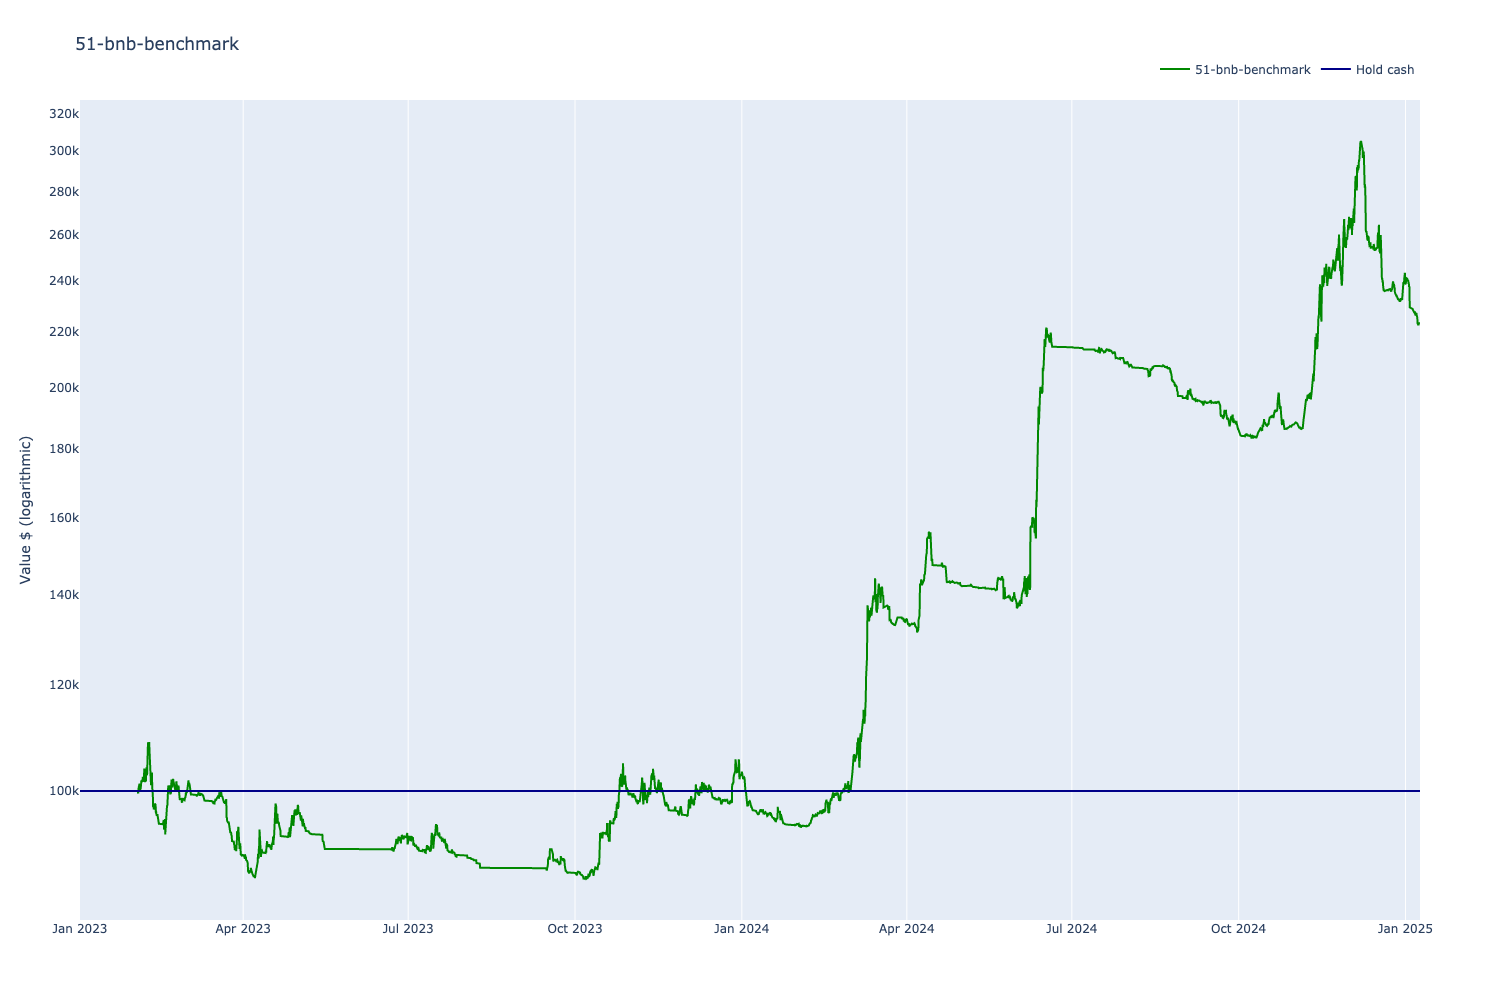

In [50]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
    start_at=state.get_trading_time_range()[0],
    interesting_assets=["WETH", "WBTC"],
)

fig = visualise_equity_curve_benchmark(
    state=state,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

## Equity curve with drawdown

- Linear curve

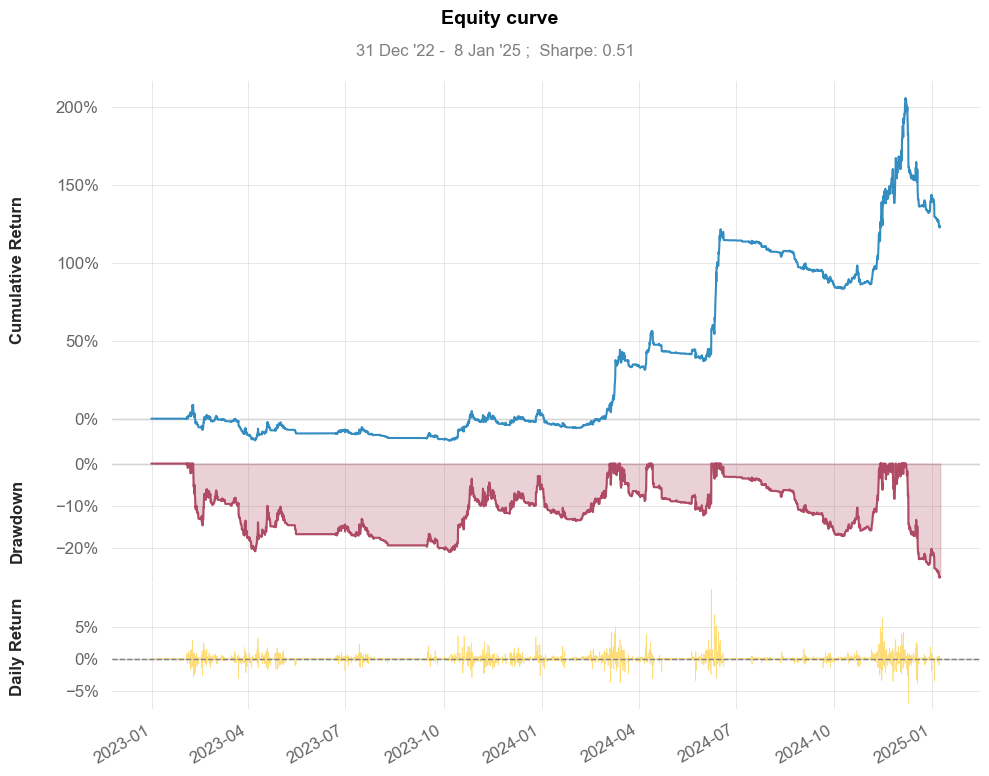

In [51]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
fig = visualise_equity_curve(returns)
display(fig)

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

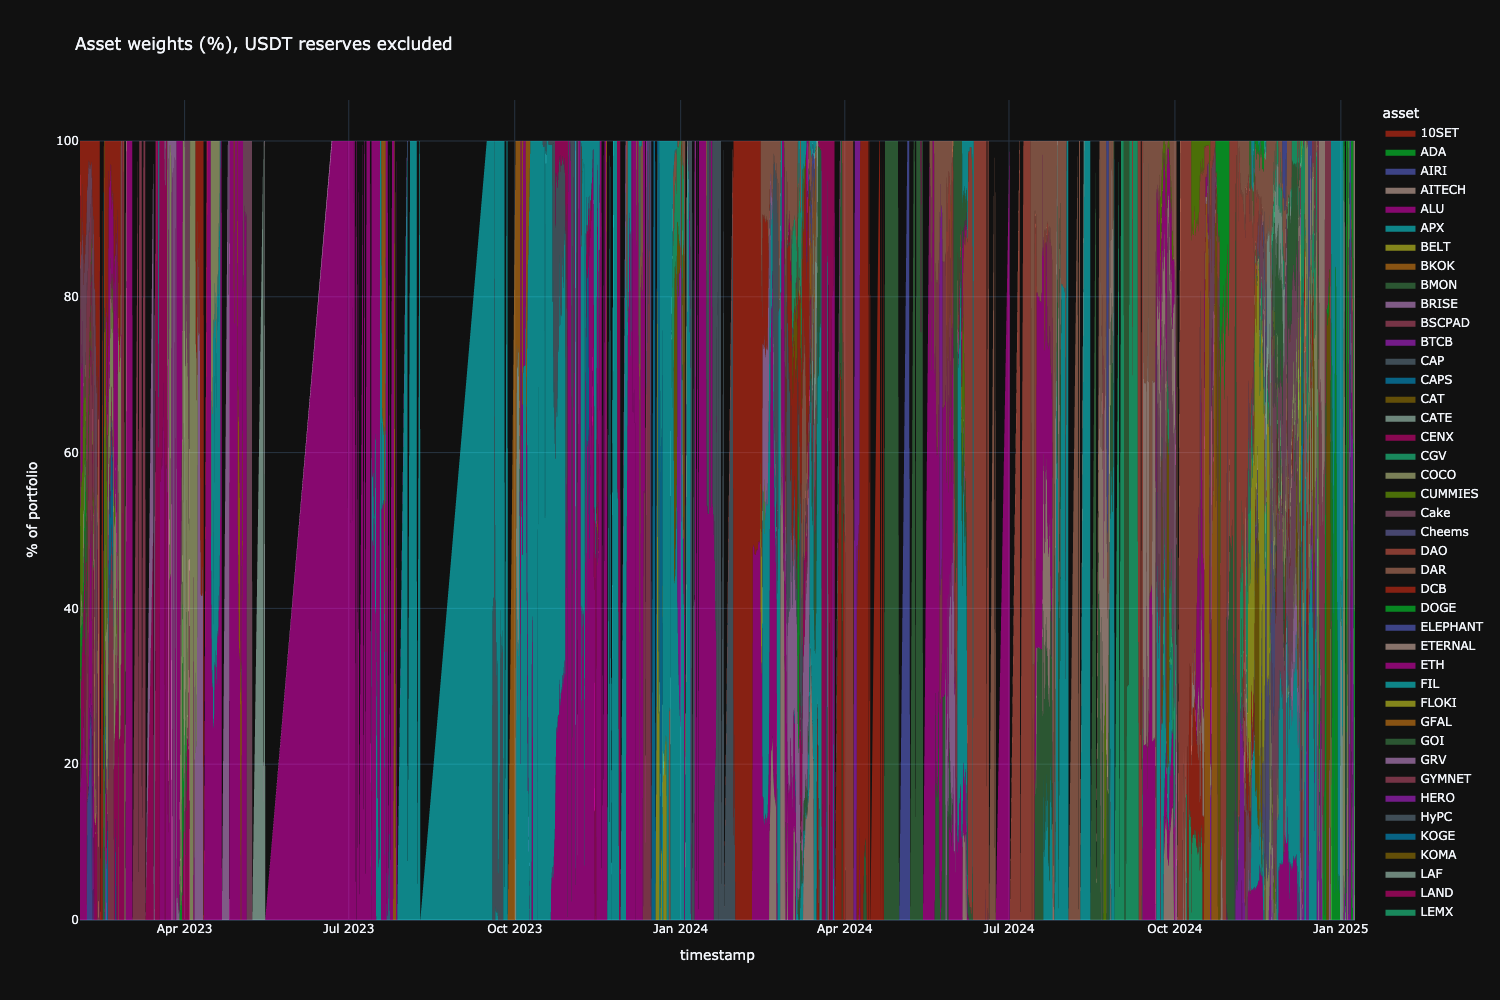

In [52]:
from tradeexecutor.analysis.weights import calculate_asset_weights, visualise_weights

weights_series = calculate_asset_weights(state)

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=False,
)
fig.show()

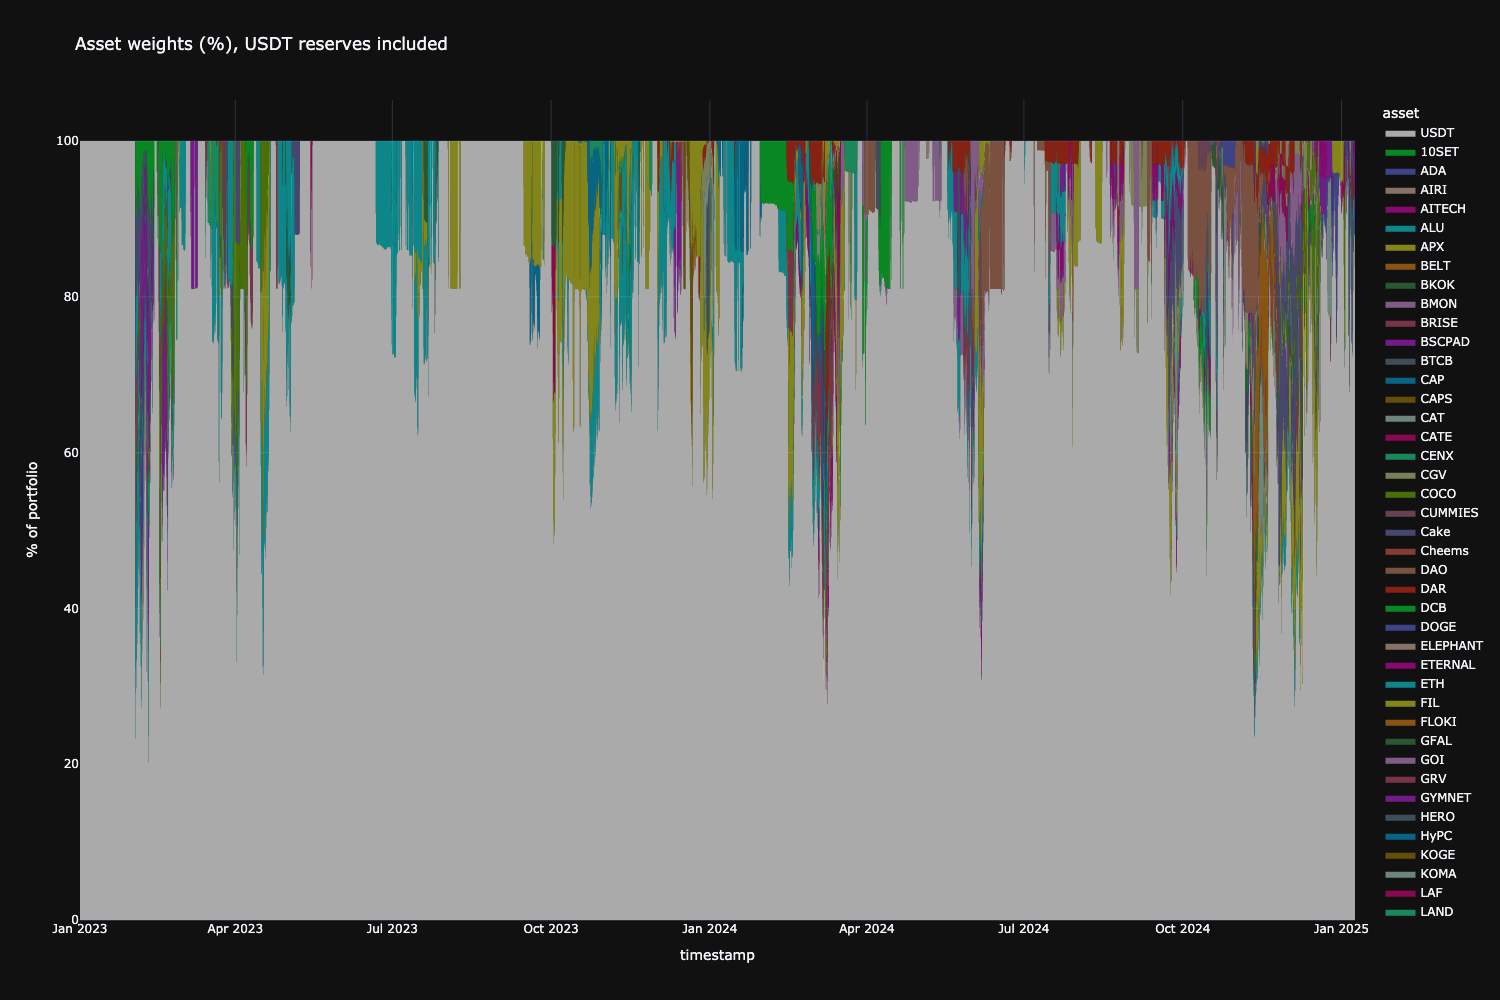

In [53]:

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=True,
)
fig.show()

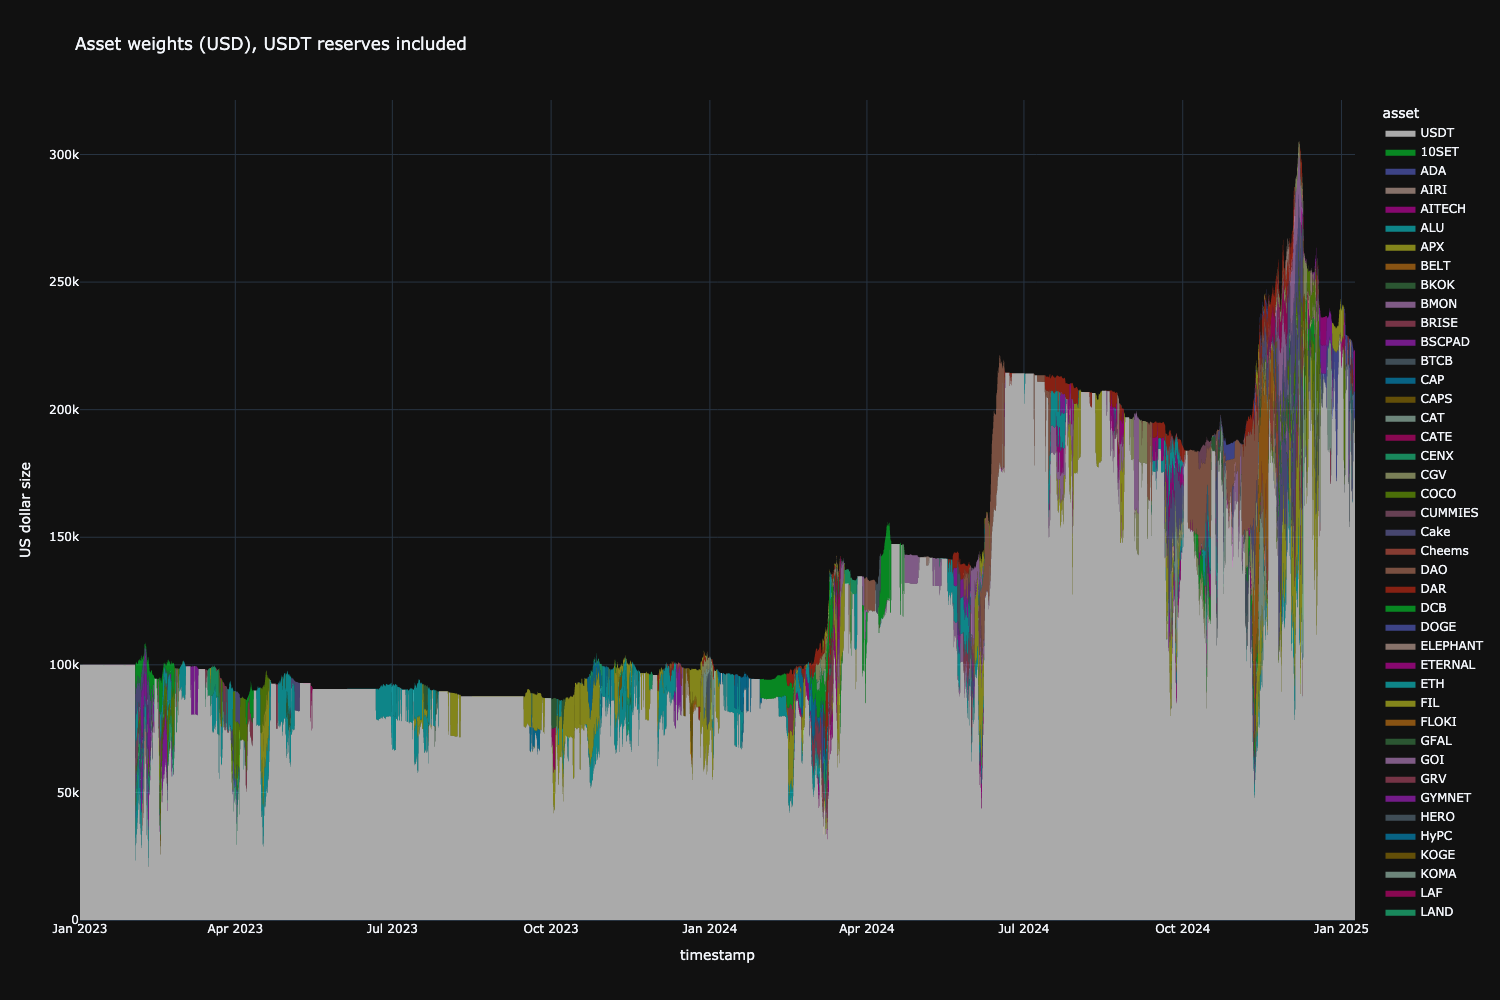

In [54]:
df = weights_series.unstack(level=1)

fig = visualise_weights(
    weights_series,
    normalised=False,
)
fig.show()

## Weight allocation statistics



In [55]:
from tradeexecutor.analysis.weights import calculate_weights_statistics

stats = calculate_weights_statistics(weights_series)
display(stats)


At   Pair      Value Unit
Name                                                                      
Max position (excluding USDT)   2024-11-19 04:00:00  FLOKI  68,858.57  USD
Min position (excluding USDT)   2024-10-19 08:00:00    VIN      37.57  USD
Mean position (excluding USDT)                              11,027.24  USD
Max position (excluding USDT)   2023-02-12 08:00:00    XVS     100.00    %
Min position (excluding USDT)   2023-10-24 00:00:00    SCT       0.19    %
Mean position (excluding USDT)                                  31.22    %
Max position (including USDT)   2023-01-01 00:00:00   USDT     100.00    %
Min position (including USDT)   2024-10-19 12:00:00    VIN       0.02    %
Mean position (including USDT)                                  30.71    %

# Positions at the end

Some example positions at the end


In [56]:

for p in list(state.portfolio.open_positions.values())[0:10]:
    print(f"Position {p.pair.base.token_symbol}, value {p.get_value()} USD")

Position XXM, value 10466.145547626367 USD
Position infinity, value 16013.20434087021 USD
Position LEMX, value 15044.270532755847 USD
Position NVB, value 1769.7650490685526 USD


Examples of strategy thinking output 

- At the end of strategy
- Reverse order - last timestamp first

In [57]:
messages = state.visualisation.get_messages_tail(2)

table = pd.Series(
    data=list(messages.values()),
    index=list(messages.keys()),
)

df = table.to_frame()

display(df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))


# Alpha model diagnostics data

- Dump out alpha model contents from the last cycle

In [58]:
from tradeexecutor.strategy.alpha_model import format_signals

alpha_model = state.visualisation.discardable_data["alpha_model"]

print(f"All signals ({len(df)})")
df = format_signals(alpha_model, signal_type="all")
display(df)

All signals (2)


Signal    Asked size  Accepted size  Value adjust USD  \
Pair                                                                     
NVB-USDT       0.000023   1778.636052    1778.636052       1778.636052   
LEMX-USDT      0.000327  24587.364351   15119.680410      15119.680410   
infinity-USDT  0.000715  47620.229641   16043.836382         30.632041   
XXM-USDT       0.002598  42394.445625   10516.773676         50.628129   

               Weights (raw)  Weights (norm/cap)  Old weight      Flipping  \
Pair                                                                         
NVB-USDT            0.000023            0.040927    0.000000  none -> spot   
LEMX-USDT           0.000327            0.347907    0.000000  none -> spot   
infinity-USDT       0.000715            0.369172    0.604743       no flip   
XXM-USDT            0.002598            0.241993    0.395257       no flip   

                   TVL                                              Flags  
Pair                                                                       
NVB-USDT       7709295                                                     
LEMX-USDT      1511968                                capped_by_pool_size  
infinity-USDT  1604384  capped_by_pool_size, individual_trade_size_too...  
XXM-USDT       1051677  capped_by_concentration, capped_by_pool_size, ...

# Trading pair breakdown

- Trade success for each trading pair



In [59]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
format_multipair_summary(multipair_summary, sort_column="Total return %")

# Trading metrics

- Trading cost, etc.

In [60]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

# Credit metrics

- How much we get out from Aave

In [61]:
from tradeexecutor.analysis.credit import calculate_credit_metrics

interest_df = calculate_credit_metrics(state)
display(interest_df)

Value
Name                        
Credit position count      0